# F20AA Applied Text Analytics: Coursework 2 - Amazon Arts & Crafts (30%)

#### Deadline: 11:59pm, Monday 1st April 2024 via Canvas group space

#### Google Colab [LINK](https://colab.research.google.com/drive/1MOFZBKWU8zxkWrY3bAL9udCeAKqL3n4M?usp=sharing)

#### Members:
- Francis Sandrino (fgs2)
- Jai Varsani (jv81)
- Ahmed Moussa Abdelfattah (asa30)
- Aamir Nazir (mn2025)

## Objectives:
In this coursework you will practice using essential text processing, representation, analysis and categorization tools.

In particular, you will gain experience in:
- Text processing techniques: tokenization, stemming, normalization and stop-word removal, ..etc
- Exploring the effect of using n-gram features vs. unigram features
- Vector space representation (binary, frequency count & tf-idf) and word-embeddings
- Experimenting with different classification models
- Presenting and comparing results to Sequence Models, deep learning models or pre-trained
models
- Topic modelling and text clustering
- Participating in a Kaggle competition

## Problem Formulation

You are given a dataset of text reviews and the corresponding ratings provided by the user. The ratings score different 'Arts and Crafts' related products to 1 (low rating) up till 5 (maximum rating).

This can be considered a multi-class classification problem where your classes are the scores provided by the user {1, 2, 3, 4, 5}. The features are the text reviews.

You are requested to use your 'analytics' skills to provide insights on the data provided and to propose a categorization system that can automatically rate similar text reviews.

## The Dataset

The original dataset consists of reviews and metadata from Amazon, including 142.8 million reviews spanning May 1996 - July 2014. The original data includes ___reviews___ (___ratings, text___, helpfulness votes), product metadata (descriptions, category information, price, brand, and image features), and links (also viewed/also bought graphs).

Dataset source: [Dataset link](http://jmcauley.ucsd.edu/data/amazon/links.html)

You will be working on _a modified subset of the __Arts and Crafts__ related product purchases._ This dataset will only include the 'Review Text' and the corresponding rating {1, 2, 3, 4, 5} provided by the user. You will be provided with a __train.csv__ file and a __test.csv__ file to use as you training/test datasets. You will use this train.csv dataset to train you models and optimize your model parameters. You will receive detailed instructions on how to participate in private class organized Kaggle competition for building a text classifier. The competition will open at least 6 weeks before the submission deadline.

<a id='home'></a>
## Table of Contents
__Note: This only works when the notebook is opened using Jupyter, not Google Colab.__
Added for quicker navigation. The linked cells also have a link back to this specific cell.

- [A. Data Exporation and Visualization](#dataExploration)
  - [Discussion: Duplicates](#dupes)
  - [Exploratory Data Analysis](#eda)
  - [Findings and Conclusions](#finds)
- [B. Text Processing and Normalization](#textProcessing)
  - [Data Preprocessing](#preprocess)
  - [Truncation and Tokenization](#truncate)
  - [Discussion: How We Handled the Size of the Dataset](#datasize)
- [C. Vector Space Model and Feature Representation](#featureRepresentation)
  - [Feature Representation](#ferep)
  - [Bag of Words (BoW)](#bow)
  - [Experiments: BoW](#expbow)
  - [N-grams](#ngram)
  - [Experiments: N-grams](#expngram)
  - [Word Embeddings](#embed)
  - [Experiments: Word Embeddings](#expembed)
  - [Discussion and Summary](#3summary)
  - [EXTRA: N-grams with Logistic Regression: Lemmatization vs Stemming](#nlog)
- [D. Model Training/Selection, Hyperparameter Tuning/Evaluation](#modelTraining)
- [E. Modelling Text as a Sequence](#modellingText)
  - [BERT](#bertbase)
  - [DistilBERT Amazon Pre-trained](#amazon)
  - [Custom Transformer](#custom)
  - [The Winning Solution](#win)
- [F. Topic Modelling of High and Low Ratings](#topicModelling)
- [References](#references)

<a id = 'dataExploration'></a>
## A. Data Exploration and Visualization
Provide an initial step to inspect, visualize, and analyze the different attributes in your dataset. Document your findings and make conclusions for your next steps.

#### Loading and displaying the training and testing dataset

In [1]:
!pip install emoji
!pip install langdetect

import emoji
import nltk
import string
import joblib
import time
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from langdetect import detect
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from IPython.display import clear_output


nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

seed = 50
testRatio = 0.2

2024-04-01 04:50:28.102928: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-01 04:50:28.157697: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-01 04:50:28.569300: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-01 04:50:30.197242: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/fgs2/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /home/fgs2/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nlt

The cell directly below this is done for convenience, either for Google Colab or skipping ahead a few steps in preprocessing to optimize our pipeline.

In [2]:
# This is so we don't have to keep uploading on Colab.

import os
import requests
from requests.auth import HTTPBasicAuth

def downloadFileFromRepo(username, repository, branch, filepath, token):
    # Construct the URL to download the file from GitHub
    url = f"https://raw.githubusercontent.com/{username}/{repository}/{branch}/{filepath}"

    # Send a GET request to download the file
    response = requests.get(url, auth=HTTPBasicAuth(username, token))

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Extract the file name from the URL
        fileName = filepath.split('/')[-1]

        # Create the 'data' directory if it doesn't exist
        if not os.path.exists('data'):
            os.makedirs('data')

        # Define the file path within the 'data' directory
        localFilepath = os.path.join('data', fileName)

        # Write the file content to a local file
        with open(localFilepath, 'wb') as f:
            f.write(response.content)
        print(f"File '{fileName}' downloaded successfully.")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")

username = ""
repository = ""
branch = ""
path_to_file = ""
repoToken = ""

downloadFileFromRepo(username, repository, branch, path_to_file, repoToken)

path_to_file = "cw2/data/trainLemmatized.csv"
downloadFileFromRepo(username, repository, branch, path_to_file, repoToken)

path_to_file = "cw2/tokenizer.json"
downloadFileFromRepo(username, repository, branch, path_to_file, repoToken)

path_to_file = "cw2/data/testLemmatized.csv"
downloadFileFromRepo(username, repository, branch, path_to_file, repoToken)

path_to_file = "cw2/data/train.csv"
downloadFileFromRepo(username, repository, branch, path_to_file, repoToken)

path_to_file = "cw2/data/test.csv"
downloadFileFromRepo(username, repository, branch, path_to_file, repoToken)

File 'trainPreprocessed.csv' downloaded successfully.
File 'trainLemmatized.csv' downloaded successfully.
Failed to download file. Status code: 404
File 'testLemmatized.csv' downloaded successfully.
File 'train.csv' downloaded successfully.
File 'test.csv' downloaded successfully.


In [3]:
# Loading training dataset and creating a review length column
reviewTrain = pd.read_csv('./data/train.csv')
reviewTrain['reviewLength'] = reviewTrain['Review'].str.len()

# Loading testing dataset and creating a review length column
reviewTest = pd.read_csv('./data/test.csv')
reviewTest['reviewLength'] = reviewTest['Review'].str.len()

# Check training dataset
reviewTrain

overall                                             Review  \
0             5  I love these glitter pens. They sparkle deligh...   
1             5  It works well with my machine.  I use mostly c...   
2             5  This is a great assortment of colors, though t...   
3             5                       Just what I was looking for.   
4             5      I make 400 birds for the hospital each month.   
...         ...                                                ...   
370858        5  I love these dies they make great backgrounds ...   
370859        5  I love Darice embossing folders.  Darcie's fol...   
370860        5  I ordered these to add to my Earthy Markers th...   
370861        4  Made perfect off white color by blending a tin...   
370862        5  I used this to make photo canvases for Christm...   

        reviewLength  
0              181.0  
1               57.0  
2              318.0  
3               28.0  
4               45.0  
...              ...  
370858          59.0  
370859         138.0  
370860         243.0  
370861         143.0  
370862         324.0  

[370863 rows x 3 columns]

In [4]:
# Check testing dataset
reviewTest

id                                             Review  \
0            0             Wonderful asst. of  wood carving tools   
1            1  Pretty lace with 4 way stretch. I was exactly ...   
2            2  This is a quick and easy way to start a crazy ...   
3            3  This is my favorite journals, the pages are ve...   
4            4  I bought this for a costume i was making. i wa...   
...        ...                                                ...   
123617  123617  I don't know that I can fully express my adora...   
123618  123618  Love this works well with machine. Good packag...   
123619  123619     It is what it is. It works. Made of cardboard.   
123620  123620  Really cool. It's durable, lightweight and ver...   
123621  123621                        Great hammer fro the price.   

        reviewLength  
0               38.0  
1               61.0  
2               58.0  
3               56.0  
4              689.0  
...              ...  
123617        1440.0  
123618          66.0  
123619          46.0  
123620         250.0  
123621          27.0  

[123622 rows x 3 columns]

#### Check (and remove) for null values

In [5]:
# Finding the number of null values per column
print("Null values per column: Training")
print(reviewTrain.isnull().sum())

Null values per column: Training
overall         0
Review          8
reviewLength    8
dtype: int64


In [6]:
# Finding the indexes of rows with null values
hasNullTr = reviewTrain[reviewTrain.isnull().any(axis = 1)].index
print("Indices with null values: Training")
print(hasNullTr)

Indices with null values: Training
Index([26709, 140678, 149137, 161123, 199465, 309619, 328716, 337056], dtype='int64')


In [7]:
# Extracting those rows to verify nullity: Training
nullRows = reviewTrain.iloc[hasNullTr]
nullRows

overall Review  reviewLength
26709         5    NaN           NaN
140678        4    NaN           NaN
149137        5    NaN           NaN
161123        5    NaN           NaN
199465        5    NaN           NaN
309619        5    NaN           NaN
328716        5    NaN           NaN
337056        5    NaN           NaN

In [8]:
# Dropping rows with null values and resetting index after row reduction: Training
reviewTrain = reviewTrain.drop(hasNullTr)
reviewTrain['reviewLength'] = reviewTrain['reviewLength'].astype(int)
reviewTrain.reset_index(drop = True, inplace = True)
reviewTrain

overall                                             Review  \
0             5  I love these glitter pens. They sparkle deligh...   
1             5  It works well with my machine.  I use mostly c...   
2             5  This is a great assortment of colors, though t...   
3             5                       Just what I was looking for.   
4             5      I make 400 birds for the hospital each month.   
...         ...                                                ...   
370850        5  I love these dies they make great backgrounds ...   
370851        5  I love Darice embossing folders.  Darcie's fol...   
370852        5  I ordered these to add to my Earthy Markers th...   
370853        4  Made perfect off white color by blending a tin...   
370854        5  I used this to make photo canvases for Christm...   

        reviewLength  
0                181  
1                 57  
2                318  
3                 28  
4                 45  
...              ...  
370850            59  
370851           138  
370852           243  
370853           143  
370854           324  

[370855 rows x 3 columns]

<a id='dupes'></a>
[Back to Table of Contents](#home)
### Discussion: Duplicates

In the context of Amazon reviews, duplicates can occur due to various reasons, such as:
- Bot-generated reviews
  - Some entities may use bots to generate fake reviews in large quantities for certain products. These reviews are often identical, or at the very least, similar in their content, which could lead to duplication.
- Product variations
  - Customers may leave identical reviews for different variations of a product (e.g., different colors, sizes)

With the given dataset, there is a large number of duplicate reviews (~96k). The duplicates aren't as simple as "good product" or "i hate it"; they can get as severe as a review with a character length of 1000+ being replicated 9 times. Ideally, we want to remove the duplicates to reduce noise and improve the quality of our dataset. However, due to the nature of reviews online, duplicates are bound to happen and are inherently a characteristic of the training and testing datasets, and more importantly, in the real world representation of the data. Hence, we will move forward with keeping the duplicates.

In [9]:
# Manual checking of duplicates: Training
duplicateTrain = reviewTrain[reviewTrain.duplicated(subset=['Review'], keep=False)]
duplicateTrain = duplicateTrain.sort_values(by = 'reviewLength', ascending = False)
duplicateTrain['reviewLength'] = duplicateTrain['reviewLength'].astype(int)
duplicateTrain.head(30)

# Duplicates are complex and are inherently part of the datasets, whether extracted for training/testing purposes or in the real-world. They are kept as part of the training process.

overall                                             Review  \
285672        4  Expression vs. Slice\nThere is no comparison -...   
253011        4  Expression vs. Slice\nThere is no comparison -...   
249969        5  <div id="video-block-RORNBTDZRUJV2" class="a-s...   
353795        5  <div id="video-block-RORNBTDZRUJV2" class="a-s...   
354953        2  I don't really scrapbook. I might start after ...   
334093        2  I don't really scrapbook. I might start after ...   
311767        5  I hate buying paper online for my drawings. I ...   
105486        5  I hate buying paper online for my drawings. I ...   
332272        5  I hate buying paper online for my drawings. I ...   
368031        5  I hate buying paper online for my drawings. I ...   
141311        5  I hate buying paper online for my drawings. I ...   
281387        5  This is an update to my original review\n.\nI'...   
47418         5  This is an update to my original review\n.\nI'...   
370450        5  NO MORE SEWING\nBeacon Fabri-Tak does an excel...   
229075        5  NO MORE SEWING\nBeacon Fabri-Tak does an excel...   
34152         3  When I first got these, I was extremely frustr...   
268059        3  When I first got these, I was extremely frustr...   
7374          3  I saw this Dritz Sweater Stone on Amazon and d...   
186844        3  I saw this Dritz Sweater Stone on Amazon and d...   
160292        5  This -seems- to be nothing more than a very th...   
243929        5  This -seems- to be nothing more than a very th...   
156221        5  I recently taught myself to crochet, and, even...   
9579          5  I recently taught myself to crochet, and, even...   
147679        5  I recently taught myself to crochet, and, even...   
309591        5  I recently taught myself to crochet, and, even...   
58835         5  I use Rit dye all the time, here are some help...   
58751         5  I use Rit dye all the time, here are some help...   
368230        5  I use Rit dye all the time, here are some help...   
350302        5  I use Rit dye all the time, here are some help...   
218050        5  I use Rit dye all the time, here are some help...   

        reviewLength  
285672         19323  
253011         19323  
249969         10379  
353795         10379  
354953          8821  
334093          8821  
311767          7478  
105486          7478  
332272          7478  
368031          7478  
141311          7478  
281387          7380  
47418           7380  
370450          5740  
229075          5740  
34152           5333  
268059          5333  
7374            5027  
186844          5027  
160292          5025  
243929          5025  
156221          4928  
9579            4928  
147679          4928  
309591          4928  
58835           4914  
58751           4914  
368230          4914  
350302          4914  
218050          4914

<a id='eda'></a>
[Back to Table of Contents](#home)
### Exploratory Data Analysis

In [10]:
reviewTrain['overall'].describe()

count    370855.000000
mean          4.566593
std           0.930385
min           1.000000
25%           5.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

#### Plotting the distribution of review scores

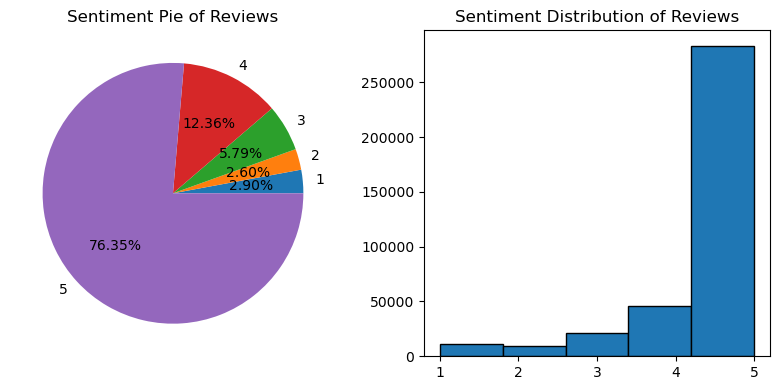

In [11]:
# Obtaining distribution of review scores
scores = ['1', '2', '3', '4', '5']
count1 = len(reviewTrain[reviewTrain['overall'] == 1]['Review'].array)
count2 = len(reviewTrain[reviewTrain['overall'] == 2]['Review'].array)
count3 = len(reviewTrain[reviewTrain['overall'] == 3]['Review'].array)
count4 = len(reviewTrain[reviewTrain['overall'] == 4]['Review'].array)
count5 = len(reviewTrain[reviewTrain['overall'] == 5]['Review'].array)

# Storing percentages
distribution = [count1, count2, count3, count4, count5]

fig, axs = plt.subplots(1, 2, figsize = (8, 4))

axs[0].pie(distribution, labels = scores, autopct = '%1.2f%%')
axs[0].set_title("Sentiment Pie of Reviews")

axs[1].hist(reviewTrain['overall'], bins = 5, edgecolor = 'black')
axs[1].set_title("Sentiment Distribution of Reviews")

plt.tight_layout()
plt.show()

We see that 5-star reviews dominate the dataset by a large margin, followed by 4, 3, 1, and 2. 

In [12]:
reviewTrain['reviewLength'].describe()

count    370855.000000
mean        165.918604
std         302.340459
min           1.000000
25%          30.000000
50%          82.000000
75%         185.000000
max       19323.000000
Name: reviewLength, dtype: float64

#### Viewing the top 20 longest reviews' scores

In [13]:
reviewTrain.sort_values(by = "reviewLength", ascending = False).head(20)

overall                                             Review  \
285672        4  Expression vs. Slice\nThere is no comparison -...   
253011        4  Expression vs. Slice\nThere is no comparison -...   
321640        5  I bought the Cameo on a whim last x-mas. I had...   
81028         5  Small update:  Nov. 4, 2017\nAs noted below, t...   
151992        5  First off, I received a Cricut Explore in exch...   
305378        5  If you haven't upgraded your Cricut (or have n...   
269987        3  UPDATE: Attempted to sew an Olaf hat and body ...   
12804         3  I am writing this review from the perspective ...   
33499         5  I just traded in my Viking Designer 1 for a us...   
353795        5  <div id="video-block-RORNBTDZRUJV2" class="a-s...   
249969        5  <div id="video-block-RORNBTDZRUJV2" class="a-s...   
312882        5  There is a large family of Goop adhesives, "Al...   
121836        5  I do a lot of art, ranging from sculpture thro...   
173182        5  If you are looking at this product, you are pr...   
116883        3  UPDATED 8/6/2014\nI had to dock this one star ...   
282912        5  The Brother DZ820E is an embroidery-only machi...   
265681        3  I began sewing well over 30 years ago on a Sin...   
142286        5  [This is the review I posted on the main listi...   
368196        5  The new Designio line by Brother is a group of...   
219883        5  This is a full size, semi-commercial, straight...   

        reviewLength  
285672         19323  
253011         19323  
321640         17767  
81028          17686  
151992         13078  
305378         12819  
269987         11604  
12804          11521  
33499          11437  
353795         10379  
249969         10379  
312882         10085  
121836          9948  
173182          9844  
116883          9769  
282912          9645  
265681          9517  
142286          9414  
368196          9146  
219883          8922

#### Applying VADER polarity on all rows for sentiment analysis

In [14]:
# Code adapted from F20AA Coursework 1
sentimentIntensityAnalyzer = SentimentIntensityAnalyzer()

# Obtains the raw polarity value without thresholding
def vaderRaw(input):
    polarity = sentimentIntensityAnalyzer.polarity_scores(input)
    return polarity['compound']

# Obtains the polarity of all reviews
reviewTrain['polarity'] = reviewTrain['Review'].apply(lambda text: vaderRaw(text))

#### Plots for review length vs overall score vs raw VADER polarity

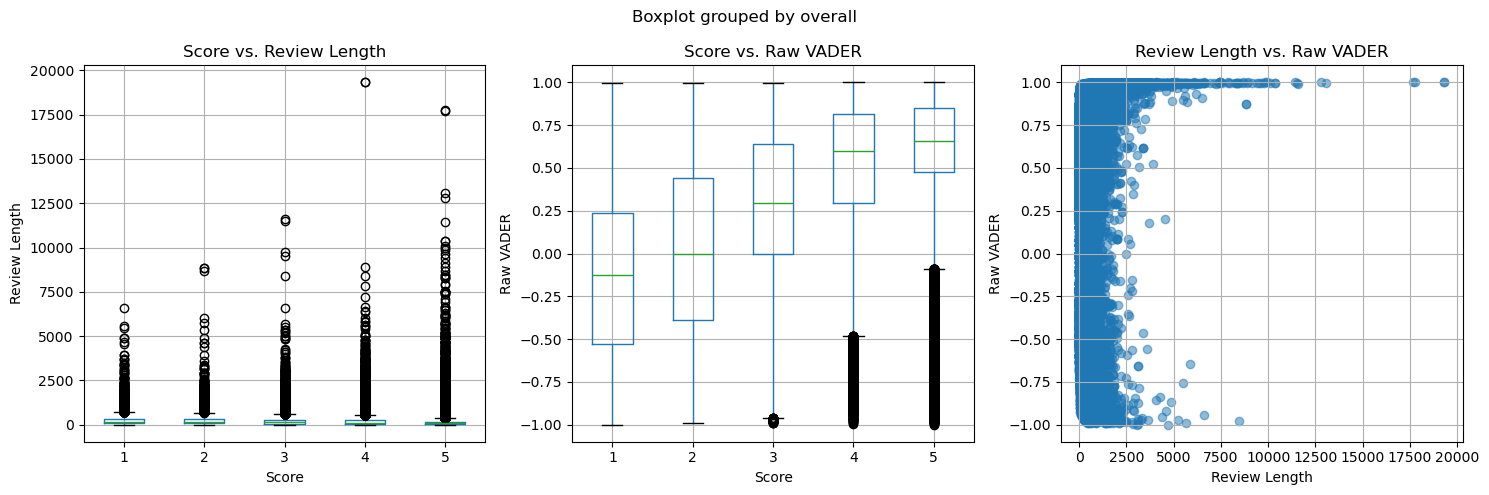

In [15]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Box plot of review length vs. overall score
reviewTrain.boxplot(by='overall', column='reviewLength', ax=axes[0])
axes[0].set_title('Score vs. Review Length')
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Review Length')
axes[0].grid(True)

# Box plot of overall score vs. raw VADER polarity
reviewTrain.boxplot(by='overall', column='polarity', ax=axes[1])
axes[1].set_title('Score vs. Raw VADER')
axes[1].set_xlabel('Score')
axes[1].set_ylabel('Raw VADER')
axes[1].grid(True)

# Scatter plot of review length vs. raw VADER polarity
axes[2].scatter(reviewTrain['reviewLength'], reviewTrain['polarity'], alpha=0.5)
axes[2].set_title('Review Length vs. Raw VADER')
axes[2].set_xlabel('Review Length')
axes[2].set_ylabel('Raw VADER')
axes[2].grid(True)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

#### Box plot of Score vs Review Length without outliers
For reference, outliers are removed **from the visualization** if they are not within $Q1 - (1.5 × IQR)$ and $Q3 + (1.5 × IQR)$ according to the [1.5x IQR rule](https://www.thoughtco.com/what-is-the-interquartile-range-rule-3126244#:~:text=Multiply%20the%20interquartile%20range%20(IQR,IQR)%20from%20the%20first%20quartile.).

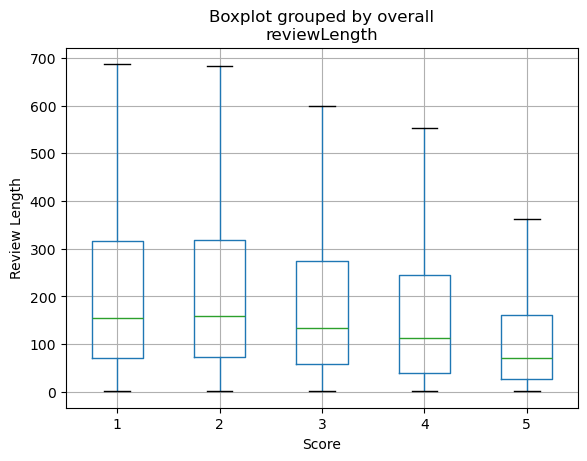

In [16]:
# Box plot of review length vs. overall score without outliers based on the formula above
reviewTrain.boxplot(by='overall', column='reviewLength', showfliers = False)
plt.xlabel('Score')
plt.ylabel('Review Length')
plt.grid(True)

# Show the plot
plt.show()

#### Finding correlations between review length, overall score and raw VADER polarity, if any

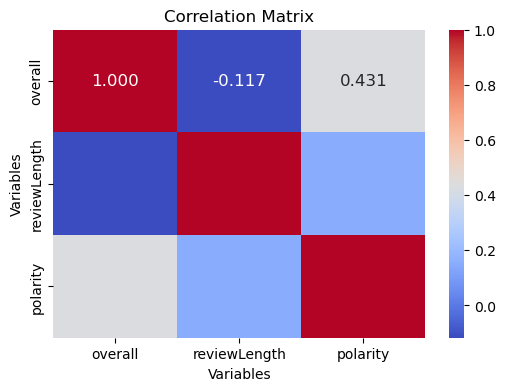

In [17]:
# Simple correlation matrix to investigate correlation between review length and score, if any
corrMatrix = reviewTrain[['overall', 'reviewLength', 'polarity']].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corrMatrix, annot=True, cmap='coolwarm', fmt=".3f", annot_kws={"size": 12})
plt.title('Correlation Matrix')
plt.xlabel('Variables')
plt.ylabel('Variables')
plt.show()

In [18]:
# Printing the correlation matrix again in case the visualization fails
corrMatrix

overall  reviewLength  polarity
overall       1.000000     -0.117211  0.431092
reviewLength -0.117211      1.000000  0.153088
polarity      0.431092      0.153088  1.000000

<a id='finds'></a>
[Back to Table of Contents](#home)
### Findings
- A total of 370,863 reviews provided for training; 370,855 after dropping reviews with null values.
- The average overall review score is around 4.57, with the median being 5, indicating, among the visualizations above, that most reviews are of 5-star reviews.
- 5-star reviews make up most of the dataset at a staggering 76.35%, while the shares reduce as the value of the score goes down until it reaches 1-star, where it's slightly above 2-star reviews, which garnered the least.
- The top 20 longest reviews range from 3 to 5 star reviews, with 5 star reviews being the majority.
- **Findings from plots**
  - ```overall``` vs ```reviewLength```: There is a visible downward trend of the review length as the review score increases, with most values following suit except for $Q1 - (1.5 × IQR)$, which stays at 0. This indicates that for non-outlier values based on the 1.5x IQR rule, there is a weak negative correlation here, which is also supported by the correlation matrix, which is around -0.12.
  - ```overall``` vs ```polarity```: There is a strong upward trend of VADER polarity values as the review score goes up, which is to be expected, and also shows that the review scores are associated with the right sentiments.
  - ```reviewLength``` vs ```polarity```: There seems to be a weak upward trend for the polarity as the review length increases, yet it only really starts showing at around 0.8 polarity. A weaker display of that is evident within values with less than -0.7 polarity, which shows that the more negative the polarity, the longer the review, albeit, again, at a smaller scale.
- **Findings from the correlation matrix**
  - Based on the correlation matrix, there is a weak negative correlation (-0.12) between ```reviewLength``` and ```overall```, and a weak positive correlation (0.15) between ```reviewLength``` and ```polarity```.
  - There is a moderate positive correlation (0.43) between ```polarity``` and ```overall```, which is intuitive as more positive sentiments should theoretically be associated with higher review scores.
### Conclusions
- The large number of reviews suggests that the training, later on, can potentially yield robust insights if used well with little need for cross-validation.
- The skew towards positive reviews suggests that buyers of these products generally have a favorable opinion of the products they have purchased.
- ```overall``` vs ```reviewLength```: The weak negative correlation suggests that, on average, longer reviews may be associated with slightly lower review scores. After some manual reviewing, this was due to longer reviews containing more critical feedback on the aspects of the product(s) that made it seem unsatisfactory in the customers' eyes.
  - It is, however, important to also note that the top 20 longest reviews had scores ranging from 3 to 5, which is contrary to what the correlation says.
  - People are less likely to have more to say when something is positive rather than negative (cognitive bias: see **negativity bias** [[1]](https://journals.sagepub.com/doi/10.1207/S15327957PSPR0504_2) and [[2]](https://psycnet.apa.org/doiLanding?doi=10.1037%2F0022-3514.75.4.887)), especially when there is an element of anonymity
  - Pseudo-anonymity in the case of Amazon users, where there is no tangible consequence if they criticize a product, is still relevant due to the nature of social media, as shown by Pan et al. (2023).
- ```reviewLength``` vs ```polarity```: The relationship is nuanced; more prominent for higher polarity values, while for strongly negative polarity values, it is present but less pronounced.
- ```overall``` vs ```polarity```: Intuitive.

<a id = 'textProcessing'></a>
[Back to Table of Contents](#home)
## B. Text Processing and Normalization
Thoroughly experiment with different text processing and normalization alternatives. Explain the trade-off and benefits of using each and justify their effectiveness for the current dataset.

First, we define a custom function to help in cleaning which removes empty cells to help ad-hoc, then we proceed with preprocessing.

In [19]:
# Checks for empty comment cells
def removeEmpty(df):
    indx = []
    for i in range(len(df)):
        if df.iloc[i]['processed'] == '':
            indx.append(i)
    return indx

reviewTrain['Review'].head(20)

0     I love these glitter pens. They sparkle deligh...
1     It works well with my machine.  I use mostly c...
2     This is a great assortment of colors, though t...
3                          Just what I was looking for.
4         I make 400 birds for the hospital each month.
5                                        not very sharp
6                          Its just a replacement blade
7                                          Great value,
8     It is just okay for me.  The plastic is a bit ...
9     Always happy when I find a great priced art gi...
10    I only received on piece of fabric.  Wasn't I ...
11    My favorite color being red, one of my favorit...
12    Good marking pen for light colored fabric. Lin...
13    These fasteners work fine but the spring is a ...
14                        Love these for all my needles
15                      Basic for sewing.  Top  quality
16    Was a gift for someone in New Zealand at a chi...
17    Great products and will order again! These

<a id = 'preprocess'></a>
[Back to Table of Contents](#home)
### Data Preprocessing

After some visual EDA on the comments, we clean the data using the following:
- Convert to lowercase
- Convert ellipses or sequences of dots to a single dot
- Remove:
  - Emails
  - URLs
  - account handles, e.g., @username
  - hashtags, e.g., #word
  - tokens/words that start with a number, e.g., 28hello
  - non-ASCII characters
  - HTML tags and line breaks
  - newline characters, i.e., \n
  - underscores
  - ellipses or sequences of dots


Things we __considered__:
- Numbers/sequences of digits:
  - ___KEEP___. Numbers, at least in our domain, are commonly used to express sentiment based on experiences or expectations related to the items' prices, sizes or other specifications.
- Emojis
  - ___KEEP___. Emojis add significant meaning to the text, especially in the domain of product reviews. We parsed these emojis using Python's ```emoji``` library.
- Remove/censor profanity
  - ___KEEP___. Profanity, although controversial, add significant meaning to the text and when kept, retain authenticity in terms of natural language use. They are used to amplify one's sentiment, which can be relevant for our purpose.

In [20]:
sw = set(stopwords.words('english'))

# Removes line breaks
print("Removing line breaks...")
reviewTrain['processed'] = reviewTrain['Review'].str.replace(r'<br>', ' ', regex=True)
# reviewTest['processed'] = reviewTest['Review'].str.replace(r'<br>', ' ', regex=True)

# Removes links, usernames, hashtags, HTML tags, and newline characters
print("Removing links, usernames, hashtags, HTML tags, and newline characters...")
reviewTrain['processed'] = reviewTrain['processed'].str.replace(r'@[^\s]+|&[^\s]*;| #[^\s]+|https?:\/\/\S+|www\.\S+|# |<[^>]+>|\\n|\n', '', regex=True)
# reviewTest['processed'] = reviewTest['processed'].str.replace(r'@[^\s]+|&[^\s]*;| #[^\s]+|https?:\/\/\S+|www\.\S+|# |<[^>]+>|\\n', '', regex=True)

# Convert to lowercase
print("Converting to lowercase...")
reviewTrain['processed'] = reviewTrain['processed'].str.lower()
# reviewTest['processed'] = reviewTest['processed'].str.lower()

# Removes ellipses
print("Removing ellipses...")
reviewTrain['processed'] = reviewTrain['processed'].str.replace(r'[.]+', '', regex=True)
# reviewTest['processed'] = reviewTest['processed'].str.replace(r'[.]+', '', regex=True)

# Removing stopwords from the text using the list of English stopwords from NLTK
reviewTrain['processed'] = reviewTrain['processed'].apply(lambda text: ' '.join([t for t in text.split(' ') if t not in sw]))
# reviewTest['processed'] = reviewTest['processed'].apply(lambda text: ' '.join([t for t in text.split(' ') if t not in sw]))

# Removing punctuations
reviewTrain['processed'] = reviewTrain['processed'].apply(lambda text: text.translate({ord(punc): None for punc in string.punctuation}))
# reviewTest['processed'] = reviewTest['processed'].apply(lambda text: text.translate({ord(punc): None for punc in string.punctuation}))

# Removing rows with empty text
cleaned = removeEmpty(reviewTrain)
# cleaned = removeEmpty(reviewTest)
# print("Cleaning rows with empty text")
reviewTrain = reviewTrain.drop(reviewTrain.index[cleaned])
# reviewTest = reviewTest.drop(reviewTest.index[cleaned])

print("Done!")
reviewTrain = reviewTrain.drop(columns = ['polarity', 'reviewLength', 'Review'])
reviewTrain.to_csv("./data/trainPreprocessed.csv", index = False)

Removing line breaks...
Removing links, usernames, hashtags, HTML tags, and newline characters...
Converting to lowercase...
Removing ellipses...
Done!


In [27]:
# Start here to avoid running above cells
reviews = pd.read_csv('./data/trainPreprocessed.csv')
reviews

overall                                          processed
0             5  love glitter pens sparkle delightfully page th...
1             5               works well machine  use mostly cones
2             5  great assortment colors though lot pinks mix s...
3             5                                            looking
4             5                      make 400 birds hospital month
...         ...                                                ...
370455        5             love dies make great backgrounds cards
370456        5  love darice embossing folders  darcies folders...
370457        5  ordered add earthy markers previously orderedi...
370458        4  made perfect white color blending tiny amount ...
370459        5  used make photo canvases christmas product rea...

[370460 rows x 2 columns]

#### Handling emojis

In [28]:
def parseEmojis(t):
    emojis = [c for c in t if c in emoji.UNICODE_EMOJI]
    return emojis

# Check for presence of emojis
reviews['emojiCount'] = reviews['processed'].apply(emoji.emoji_count)
reviews.sort_values(by = 'emojiCount')

overall                                          processed  emojiCount
0             5  love glitter pens sparkle delightfully page th...           0
246978        5  plaid 30piece craft brush setdurableworks acry...           0
246977        5                                              great           0
246976        4  ordered case would need sooner later  shipped ...           0
246975        5  beautiful especially black cardstock small lam...           0
...         ...                                                ...         ...
123482        5                                        works great           0
123481        5  ok im seamstress textile knowledge experience ...           0
123480        5           like scissors lot  light weight cut well           0
123478        1                                               fake           0
370459        5  used make photo canvases christmas product rea...           0

[370460 rows x 3 columns]

Since there are no emojis both in the original and processed version, we don't need to attempt to parse them. Then, we remove all unnecessary columns, two of which were used for EDA, to save memory.

In [29]:
reviews = reviews.drop(columns = ['emojiCount'])
reviews

overall                                          processed
0             5  love glitter pens sparkle delightfully page th...
1             5               works well machine  use mostly cones
2             5  great assortment colors though lot pinks mix s...
3             5                                            looking
4             5                      make 400 birds hospital month
...         ...                                                ...
370455        5             love dies make great backgrounds cards
370456        5  love darice embossing folders  darcies folders...
370457        5  ordered add earthy markers previously orderedi...
370458        4  made perfect white color blending tiny amount ...
370459        5  used make photo canvases christmas product rea...

[370460 rows x 2 columns]

#### Plotting simplified polarities per class as additional EDA

In [30]:
sentimentIntensityAnalyzer = SentimentIntensityAnalyzer()

def vaderSentimentAnalysis(i):
    polarity = sentimentIntensityAnalyzer.polarity_scores(i)
    if polarity['compound'] >= 0.05:
        return 1
    elif polarity['compound'] <= -0.05:
        return -1
    else:
        return 0

reviews['polarity'] = reviews['processed'].apply(lambda text: vaderSentimentAnalysis(text))
reviews

overall                                          processed  polarity
0             5  love glitter pens sparkle delightfully page th...         1
1             5               works well machine  use mostly cones         1
2             5  great assortment colors though lot pinks mix s...         1
3             5                                            looking         0
4             5                      make 400 birds hospital month         0
...         ...                                                ...       ...
370455        5             love dies make great backgrounds cards         1
370456        5  love darice embossing folders  darcies folders...         1
370457        5  ordered add earthy markers previously orderedi...         1
370458        4  made perfect white color blending tiny amount ...         1
370459        5  used make photo canvases christmas product rea...         1

[370460 rows x 3 columns]

#### Plotting simplified polarities (1, 0, -1) from preprocessed text based on overall Amazon review score

/tmp/ipykernel_104181/1775555681.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['5' '5' '5' ... '5' '4' '5']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  toPlot.loc[:, 'overall'] = toPlot['overall'].astype(str)
/tmp/ipykernel_104181/1775555681.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1' '1' '1' ... '1' '1' '1']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  toPlot.loc[:, 'polarity'] = toPlot['polarity'].astype(str)


       overall polarity
0            5        1
1            5        1
2            5        1
3            5        0
4            5        0
...        ...      ...
370455       5        1
370456       5        1
370457       5        1
370458       4        1
370459       5        1

[370460 rows x 2 columns]


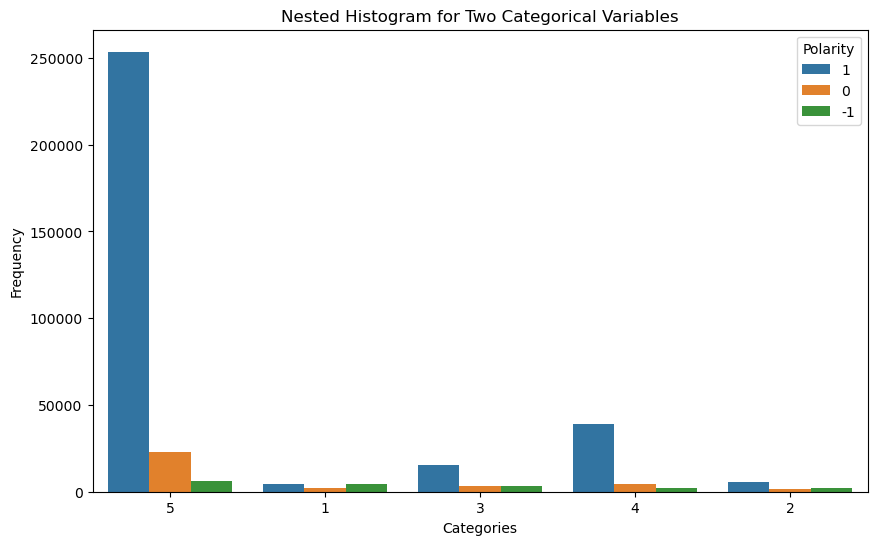

In [31]:
toPlot = reviews[['overall','polarity']]

toPlot.loc[:, 'overall'] = toPlot['overall'].astype(str)
toPlot.loc[:, 'polarity'] = toPlot['polarity'].astype(str)

print(toPlot)

plt.figure(figsize=(10, 6))
sns.countplot(data=toPlot, x='overall', hue='polarity')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.title('Nested Histogram for Two Categorical Variables')
plt.legend(title='Polarity')
plt.show()

The above graph is to be expected since as the overall review goes down, the skew should go to the opposite direction, indicating a worse overall sentiment polarity as the review score goes down.

<a id = 'truncate'></a>
[Back to Table of Contents](#home)
### Truncation and Tokenization
#### Lemmatization vs Stemming
- __Lemmatization:__
  - reducing words to their base or dictionary forms, known as lemmas
  - considers context and grammatical structure for mapping to lemmas
  - _Pros:_ takes context/grammar into account, more accurate in terms of natural language, hypothetically better for pre-trained models
  - _Cons:_ slower, more complex
- __Stemming:__
  - removes suffixes from words to extract their root or stem
  - applies heuristic rules to truncate word endings without considering context
  - _Pros:_ faster, straightforward
  - _Cons:_ does not consider context/grammar, less interpretable

Since the task in question is related to text classification, where accuracy and interpretability are critical, __lemmatization__ is ___hypothetically better___ for our use case because it produces meaningful base forms of words, instead of heuristically truncating, which can yield less accurate base forms in terms of linguistics. This will prove to be helpful later when dealing with more complex models.

**NOTE**: We will, however, be experimenting with both raw and preprocessed data during training in the latter cells of this notebook since some pre-trained models we have used are trained on actual English words/sentences that have not been reduced to their base forms.


In [42]:
reviews

overall  polarity                                          processed
0             5         1  love glitter pens sparkle delightfully page th...
1             5         1               works well machine  use mostly cones
2             5         1  great assortment colors though lot pinks mix s...
3             5         0                                            looking
4             5         0                      make 400 birds hospital month
...         ...       ...                                                ...
370455        5         1             love dies make great backgrounds cards
370456        5         1  love darice embossing folders  darcies folders...
370457        5         1  ordered add earthy markers previously orderedi...
370458        4         1  made perfect white color blending tiny amount ...
370459        5         1  used make photo canvases christmas product rea...

[370460 rows x 3 columns]

<a id = 'datasize'></a>
[Back to Table of Contents](#home)
### Discussion: How We Handled the Size of the Dataset for This Step and Latter Steps
Due to the size of the dataset, anytime we tried our approach from CW 1, which was to operate directly on the dataset, the kernel kept crashing both on Jupyter Notebook and Google Colab due to insufficient RAM. Hence, we made use of TensorFlow's ```data.experimental.make_csv_dataset``` function [(see documentation here)](https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset), which allows us to truncate (as well as tokenize and train later), by processing the dataset in batches with arbitrary batch size.

We did however run into a small issue with the batch size, where too small of a batch size took longer than expected, and a bigger batch size still occupied a significant space in RAM. We were able to find a balance at 256, but changed to smaller batch sizes when training some models.

In [44]:
streamBatchSize = 256
dataset = tf.data.experimental.make_csv_dataset("data/trainPreprocessed.csv",
                                                batch_size = streamBatchSize,
                                                select_columns = ["processed", "overall"],
                                                label_name = "overall",
                                                num_epochs = 1,
                                                shuffle = False,
                                                shuffle_buffer_size = int(streamBatchSize*1.5))

#### Lemmatization and Stemming

To handle the dataset, we lemmatized/stemmed in batches until we reached the end. Thereafter, we tokenized the two groups (lemma, stem) of  documents respectively using ```tf.keras.preprocessing.text.Tokenizer()```. This is what we will consistently use as a base for text representation later, except for when we need proprietary tokenizers, like for BERT models and its derivations.

In [26]:
%%time

# Create an iterator for the loaded dataset
iterator = iter(dataset)

# Instantiate/create required components for lemmatization and progress tracking
lemmatizer = WordNetLemmatizer()
lemmatizedDocs = []
labels = []
tokenizer = tf.keras.preprocessing.text.Tokenizer()
progress = 0

# Main loop over the dataset for lemmatization
try:
  while True:
    # Admin stuff
    progress = progress + 1
    clear_output(wait = True)
    print(f"Batch number: {progress}")

    # Obtain batch of text and decode as a list
    # The need to decode comes from the fact that strings are encoded by make_csv_dataset() as byte strings, e.g. b'Hello World'.
    batch = next(iterator)
    current = batch[0]['processed'].numpy().tolist()
    decoded = list(map((lambda x : x.decode()), current))

    # Keep track of labels of each batch
    currentLabels = batch[1].numpy().tolist()

    # Lemmatize the tokenized batch
    for i, doc in enumerate(decoded):
      tokens = word_tokenize(doc)
      lemmatizedTokens = [lemmatizer.lemmatize(t) for t in tokens]
      lemmatizedDoc = ' '.join(lemmatizedTokens)
      lemmatizedDocs.append(lemmatizedDoc)
      labels.append(currentLabels[i])

except StopIteration:
  print("End of iterator reached.")

# Fitting and saving tokenizer
tokenizer.fit_on_texts(lemmatizedDocs)
tokenizerJSON = tokenizer.to_json()
with open("tokenizer.json", "w") as jsonFile:
  jsonFile.write(tokenizerJSON)

vocabSize = len(tokenizer.word_index)
print("Vocabulary size: ", vocabSize)
print("Label size: ", len(labels))

dataset = pd.DataFrame({'data' : lemmatizedDocs, 'labels' : labels})
dataset.to_csv("data/trainLemmatized.csv", index = False)

Batch number: 1449
End of iterator reached.
Vocabulary size:  77413
Label size:  370460
CPU times: user 1min 50s, sys: 2.35 s, total: 1min 52s
Wall time: 1min 53s


In [32]:
%%time

iterator = iter(dataset)

stemmer = nltk.stem.PorterStemmer()
stemmedDocs = []
labels = []
tokenizer = tf.keras.preprocessing.text.Tokenizer()
progress = 0

try:
  while True:
    # Admin stuff
    progress = progress + 1
    clear_output(wait = True)
    print(f"Batch number: {progress}")

    # Obtain batch of text as a list
    batch = next(iterator)
    current = batch[0]['processed'].numpy().tolist()
    decoded = list(map((lambda x : x.decode()), current))

    # Keep track of labels of each batch
    currentLabels = batch[1].numpy().tolist()

    # Stem the tokenized batch
    for i, doc in enumerate(decoded):
      tokens = word_tokenize(doc)
      stemmedTokens = [stemmer.stem(t) for t in tokens]
      stemmedDoc = ' '.join(stemmedTokens)
      stemmedDocs.append(stemmedDoc)
      labels.append(currentLabels[i])

except StopIteration:
  print("End of iterator reached.")

# Fitting and saving tokenizer
tokenizer.fit_on_texts(stemmedDocs)
tokenizerJSON = tokenizer.to_json()
with open("tokenizer.json", "w") as jsonFile:
  jsonFile.write(tokenizerJSON)

vocabSize = len(tokenizer.word_index)
print("Vocabulary size: ", vocabSize)
print("Label size: ", len(labels))

dataset = pd.DataFrame({'data' : stemmedDocs, 'labels' : labels})
dataset.to_csv("data/trainStemmed.csv", index = False)

Batch number: 1449
End of iterator reached.
Vocabulary size:  64940
Label size:  370460
CPU times: user 3min 48s, sys: 2.83 s, total: 3min 51s
Wall time: 3min 54s


From the above, we can see that lemmatization took less time to finish than stemming, which is contrary to theory since lemmatization has dictionary lookups. We did, however, end up with a smaller vocabulary size for the stemmed version because of the heuristic method of truncation. 

In the end, we used the lemmatized dataset for most of our experiments, except toward the end with pre-trained models, where we tried both the lemmatized version and the raw text without preprocessing. The rationale for attempting the latter is that pre-trained models were trained on large corpora like Wikipedia, and hence it should hypothetically fit better for those models.

<a id = 'featureRepresentation'></a>
[Back to Table of Contents](#home)
## C. Vector Space Model and Feature Representation
Experiment with different representation techniques. Document your findings and make conclusions. Show how choosing n-gram features can influence your results.

This section is quite similar to our implementation in CW 1, but more focused on n-grams and word embeddings which are relevant/essential to capture intrinsic relationships within tokens in a document.

<a id = ferep></a>
[Back to Table of Contents](#home)
### Feature Representation
Three main options will be evaluated here for use later on in training:
- Bag of Words (BoW): Binary, Count, and TF-IDF
- n-grams
- Word Embeddings: Skipgrams, Continuous Bag of Words (CBow), Embedding Layers in neural networks

### Note
For experimentation in this section, we will only take a small part of the entire dataset for visualization/manual analysis since we aren't training yet. Thereafter, experiments with a baseline model, in this case a simple (in terms of layers, not computational costs) neural network would work, if only to compare the results between ```count```, ```binary```, and ```tfidf``` modes.

In [34]:
# Loading tokenizer from the JSON files
with open("lemmaTokenizer.json", "r") as json_file:
    tokenizerJSON = json_file.read()
    lemmaTokenizer = tf.keras.preprocessing.text.tokenizer_from_json(tokenizerJSON)
lemmaVocabSize = len(lemmaTokenizer.word_index)
print(f"Lemmatized Tokenizer loaded successfully with {lemmaVocabSize} words.")

# Loading a small fraction of the dataset for manual analysis
reviews = reviews.drop(columns = ['polarity'])
reviews

Lemmatized Tokenizer loaded successfully with 77413 words.


overall                                          processed
0             5  love glitter pens sparkle delightfully page th...
1             5               works well machine  use mostly cones
2             5  great assortment colors though lot pinks mix s...
3             5                                            looking
4             5                      make 400 birds hospital month
...         ...                                                ...
370455        5             love dies make great backgrounds cards
370456        5  love darice embossing folders  darcies folders...
370457        5  ordered add earthy markers previously orderedi...
370458        4  made perfect white color blending tiny amount ...
370459        5  used make photo canvases christmas product rea...

[370460 rows x 2 columns]

In [40]:
# Obtaining a small part of the dataset for vector space model/feature representation analysis
xAnalysis, _, yAnalysis, _ = train_test_split(reviews['processed'], reviews['overall'], test_size = 0.999, stratify = reviews['overall'], random_state = seed)
print(xAnalysis.head(10))
print(yAnalysis.head(10))

210592           one nicest scrapbooks ever seen heavy duty
1947                decent color std craft paint good price
58089     amazing purchased make quick work cutting 4 la...
131497                                great set stays sharp
159420                                            nice yarn
229596    good stabilizer ive made countless embroidered...
195607                                          love stamps
3110      color selection good  used acrylic paints yet ...
194136    great shape using entire sheet foam mounts  li...
200311    great tearaway stabilizer items towels burp cl...
Name: processed, dtype: object
210592    5
1947      3
58089     5
131497    5
159420    5
229596    5
195607    5
3110      5
194136    5
200311    5
Name: overall, dtype: int64


<a id = 'bow'></a>
[Back to Table of Contents](#home)
### Bag of Words (BoW)
- aka unigrams
- a representation where words are treated as dimensions with values corresponding to word frequencies
- disregards context, grammar, and order of appearance
- often used by machine learning models
- sufficient for applications such as classification, topic modelling, and recommendation systems

#### TF-IDF (Term Frequency - Inverse Document Frequency)
- counts the number of times each word occurs in a document
- uses occurence frequencies to indicate relative importance of a word in a certain document
- __Term Frequency (TF)__:
  - how often a term appears in a document
  - $t_d =$ number of times the term $t$ has occurred in document $d$
  - $t_n =$ total number of terms in document $d$
  - $TF(t, d) = \frac{t_d}{t_n}$
- __Inverse Document Frequency (IDF)__
  - measures the rarity of a term $t$ across the entire corpus
  - $d_n =$ total number of documents
  - $d_t =$ number of documents containing term $t$
  - $IDF(t) = ln(\frac{d_n}{d_t})$ 
- __TF-IDF weighting__
  - obtained by multiplying TF * IDF scores for each term in each document
  - $TFIDF(t, d) = TF(t, d) * IDF(t)$
- terms with higher TF-IDF scores are more important or relevant to the document
- terms with lower TF-IDF scores are less important or more common across the corpus

Here, we make use of Keras' ```Tokenizer.texts_to_matrix()``` function, which was enabled by our tokenizer fitting from above, just after lemmatization. 
- It tokenizes the input texts where each token is an index which represents a word in the vocabulary of the trained tokenizer
- It counts the occurrences of each token in each text using actual frequency or binary (whether it has occurred or not) and optionally applies weighting (TF-IDF) should the user choose to do so
- It then constructs a matrix where each row represents a document and each column represents a unique token/word in the vocabulary. Each value may represent either the count or weight of a token
- Possible options: ```binary```, ```count```, ```tfidf```
  - ```binary```: 1 if the token is in the text, 0 otherwise
  - ```count```: the number of times the token occurs in the text
  - ```tfidf```: applies TF-IDF weighting
First, we check what it will look like when ```mode = count``` for the ```lemmaTokenizer.texts_to_matrix()``` function:


In [48]:
toCount = lemmaTokenizer.texts_to_matrix(xAnalysis, mode = 'count')
toBinary = lemmaTokenizer.texts_to_matrix(xAnalysis, mode = 'binary')
toTFIDF = lemmaTokenizer.texts_to_matrix(xAnalysis, mode = 'tfidf')

# Count Analysis
print("Count Analysis:")
minVal = maxVal = toCount[0][0]
# Iterate over all elements in the nested lists
for doc in toCount:
    for value in doc:
        # Update min and max values if necessary
        minVal = min(minVal, value)
        maxVal = max(maxVal, value)
# Calculate the range
valRange = maxVal - minVal
print(f"Range of values: {valRange}")
print(f"Min: {minVal}, Max: {maxVal}")
print(toCount[:5])
print()

# Binary analysis
print("Binary Analysis:")
minVal = maxVal = toBinary[0][0]
for doc in toBinary:
    for value in doc:
        # Update min and max values if necessary
        minVal = min(minVal, value)
        maxVal = max(maxVal, value)
# Calculate the range
valRange = maxVal - minVal
print(f"Range of values: {valRange}")
print(f"Min: {minVal}, Max: {maxVal}")
print(toBinary[:5])
print()

# TF-IDF
print("TF-IDF")
minVal = maxVal = toTFIDF[0][0]
for doc in toTFIDF:
    for value in doc:
        # Update min and max values if necessary
        minVal = min(minVal, value)
        maxVal = max(maxVal, value)
# Calculate the range
valRange = maxVal - minVal
print(f"Range of values: {valRange}")
print(f"Min: {minVal}, Max: {maxVal}")
print(toTFIDF[:5])

Count Analysis:
Range of values: 5.0
Min: 0.0, Max: 5.0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Binary Analysis:
Range of values: 1.0
Min: 0.0, Max: 1.0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

TF-IDF
Range of values: 20.536789948481683
Min: 0.0, Max: 20.536789948481683
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.66232724 1.99560652 ... 0.         0.         0.        ]
 [0.         1.66232724 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


**Count**: The range of values indicates that the maximum count of any token in a document is 5, while some documents may have no occurrences of certain tokens (min value of 0).

**Binary**: Intuitive, 1 if it appears, 0 if it doesn't.

**TF-IDF**: This representation weighs the importance of each token in a document relative to its frequency in the entire corpus. TF-IDF considers both the frequency of a token in a document (term frequency) and the rarity of the token in the corpus (inverse document frequency). The range of values indicates the variability in the importance of different tokens across documents.

<a id = 'expbow'></a>
[Back to Table of Contents](#home)
### Experiments: BoW
Here, and in latter experiments before Section D., we ran our baseline models and actual tokenization methods in other notebooks that ran in Google Colab to parallelize our operations. The cells below were therefore copy-pasted from those notebooks. For reference to the actual notebooks, please contact any one of our team members.

**Baseline ANN Architecture**
- ```Dense(256, activation='relu')```: A fully connected layer with 256 neurons and a ReLU activation function.
- ```Dense(128, activation='relu')```: A fully connected layer with 128 neurons and a ReLU activation function.
- ```Dense(5, activation='softmax')```: An output layer with 5 neurons and a softmax activation function, which represents the output probabilities for each class.

**Methodology**
- Based on the [discussion](#datasize) on how we handled the size of the dataset for training, we opted to use the entire training dataset for training/validation since we will lose a significant amount of data in the event that the chosen sample is not representative, which is easy to mess up considering that the input data is text.
- Summary of the steps:
  - Load the dataset using ```tf.data.experimental.make_csv_dataset()```
  - Load the tokenizer using ```tf.keras.preprocessing.text.tokenizer_from_json()``` from a previously saved JSON file representing the trained tokenizer
  - Instantiate the model architecture as specified above with hyperparameters:
    - ```optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']```
  - Iterate through the loaded dataset in batches with ```trainBatchSize = 256```, which was the biggest that Colab can handle without using up all the GPU RAM. It can handle 512, but we had to run it one at a time and not the entire file at once.
    - Obtain batch of text as a list with processing steps, e.g., ```decode()```, because of how the dataset is loaded via ```tf.data.experimental.make_csv_dataset()```
    - Convert the batch of text to a matrix of a chosen mode (binary, count, tfidf) using ```lemmaTokenizer.texts_to_matrix(decoded, mode = '____')```
    - One-hot encoding for the labels since we are using softmax
    - Train test split with ```ratio = 0.15```, fit and track metrics
- The only independent variables here are the modes: ```binary```, ```count```, and ```tfidf```
   
**IMPORTANT**: We will largely be following this set of steps for training in later stages, except for when we get to some of the pre-trained models, where fine-tuning reduces resource usage.

Output from external notebook:

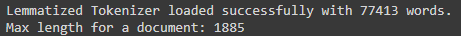

#### Final outputs
Final outputs from the external notebook, truncated to the final batches with summary metrics for brevity:

**Interpretation**
- Batch number: Current batch the model is training on
- Batch loss: Measured loss from the current batch
- Batch accuracy: Measures accuracy from the current batch
- (IGNORE, default value) Max accuracy: Max accuracy on unseen training data, 0.15 ratio
- (IGNORE, default value) Latest accuracy: Latest measured accuracy on unseen training data
- Average accuracy: Average measured accuracy over all iterations on unseen training data



With ```mode = count```:

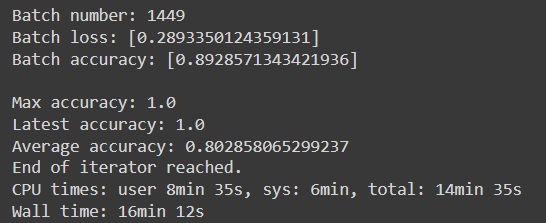
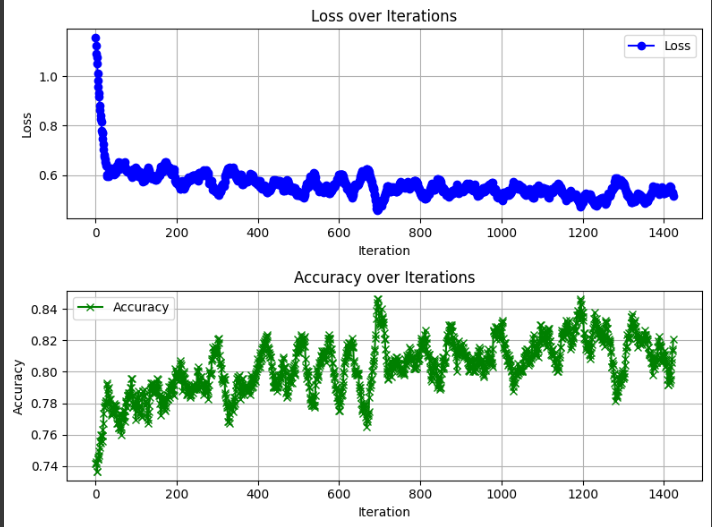

With ```mode = binary```:

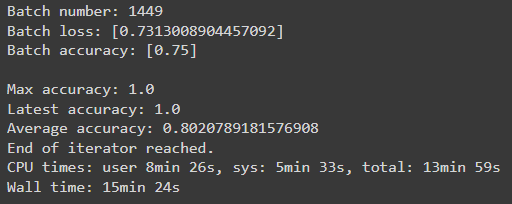
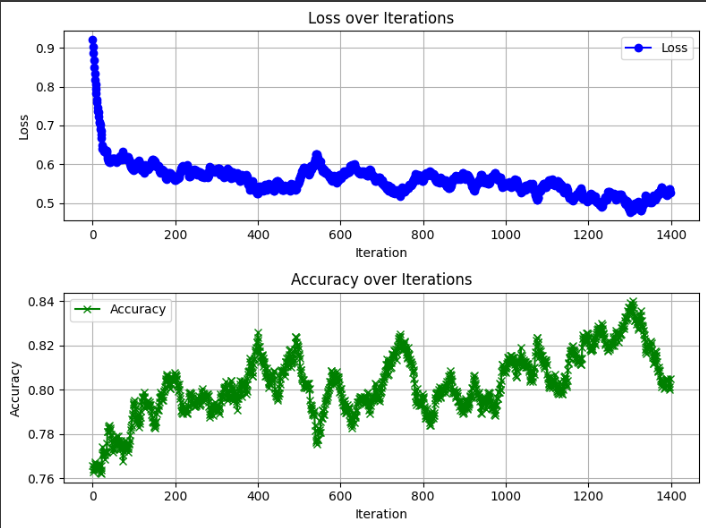

With ```mode = tfidf```:

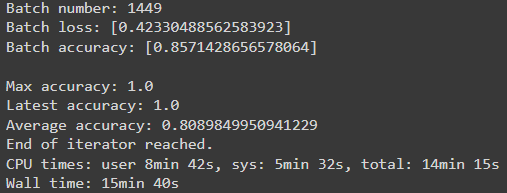
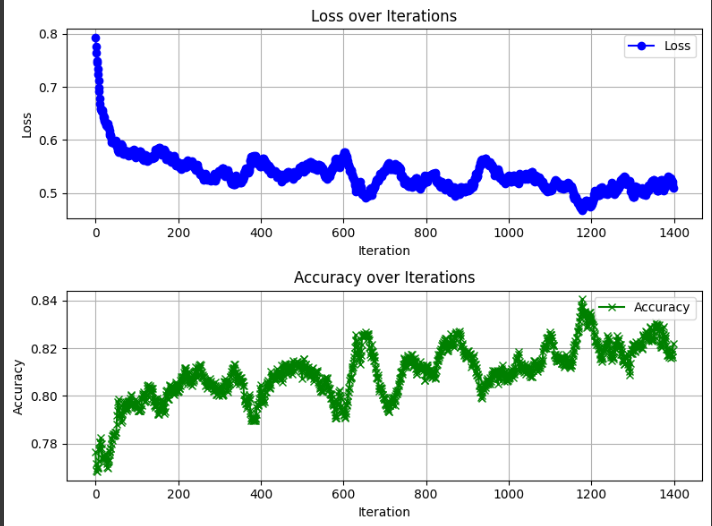

<a id = 'ngram'></a>
[Back to Table of Contents](#home)
#### N-grams
- contiguous sequences of n items (words, characters, or other tokens) extracted from a corpus
- unigrams, bigrams; can extend to tri-grams, 4-grams, or 5-grams, but has diminishing returns
- in general, this is an insufficient representation due to the long-distance dependencies of token/words for context in natural languages
- however, in most cases, empirically, local information is sufficient, so we can get away with using n-gram models

In this notebook, we will be looking at bigrams and trigrams.
#### Bigrams (2-grams)
- example: "natural language processing" → ["natural language", "language processing"]
- bigrams capture local word relationships and can provide more context compared to unigrams
- bigrams may suffer from sparsity issues, especially in large vocabularies like ours, and may not capture long-range dependencies in the text
#### Trigrams (3-grams)
- example: "natural language processing" → ["natural language processing"]
- trigrams capture more complex relationships between words and can provide richer context compared to bigrams
- they are useful for tasks where capturing mid-range dependencies is important
- trigrams may suffer from even greater sparsity issues and require larger amounts of training data compared to bigrams

<a id = 'expngram'></a>
[Back to Table of Contents](#home)
### Experiments: N-grams

The overall methodology here is similar to the experiments with BoW. It has the same model architecture and same main training/validation flow. The **main difference** is that we will be fitting another tokenizer based on the generated n-grams, then processing the text as **sequences** instead of **matrices**.

**Baseline ANN Architecture**
- ```Dense(256, activation='relu')```: A fully connected layer with 256 neurons and a ReLU activation function.
- ```Dense(128, activation='relu')```: A fully connected layer with 128 neurons and a ReLU activation function.
- ```Dense(5, activation='softmax')```: An output layer with 5 neurons and a softmax activation function, which represents the output probabilities for each class.

**Methodology**
- Based on the [discussion](#datasize) on how we handled the size of the dataset for training, we opted to use the entire training dataset for training/validation since we will lose a significant amount of data in the event that the chosen sample is not representative, which is easy to mess up considering that the input data is text.
- Summary of the steps:
  - Load the dataset using ```tf.data.experimental.make_csv_dataset()```
  - Load the tokenizer using ```tf.keras.preprocessing.text.tokenizer_from_json()``` from a previously saved JSON file representing the trained tokenizer
  - Instantiate the model architecture as specified above with hyperparameters:
    - ```optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']```
  - Iterate through the loaded dataset in batches with ```trainBatchSize = 256```, which was the biggest that Colab can handle without using up all the GPU RAM. It can handle 512, but we had to run it one at a time and not the entire file at once.
    - Obtain batch of text as a list with processing steps, e.g., ```decode()```, because of how the dataset is loaded via ```tf.data.experimental.make_csv_dataset()```
    - Generate n-grams (with ```n = 2``` or ```3```) for each document, then fit into a new tokenizer
    - Convert the batch of texts to sequences of n-grams using the tokenizer, than pad the sequences with ```maxlen = 200``` to make it easier to run
    - One-hot encoding for the labels since we are using softmax
    - Fit and track metrics
- The only independent variables here are n in n-grams: 2 and 3
   
**IMPORTANT**: We will largely be following this set of steps for training in later stages, except for when we get to some of the pre-trained models, where fine-tuning reduces resource usage.

The code above remains the same for bigrams and trigrams except for the variable n, which is changed from 2 to 3.

#### Final outputs
Final outputs from the external notebook, truncated to the final batches with summary metrics for brevity:

**Bigrams**

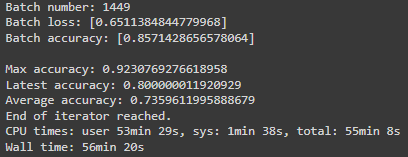
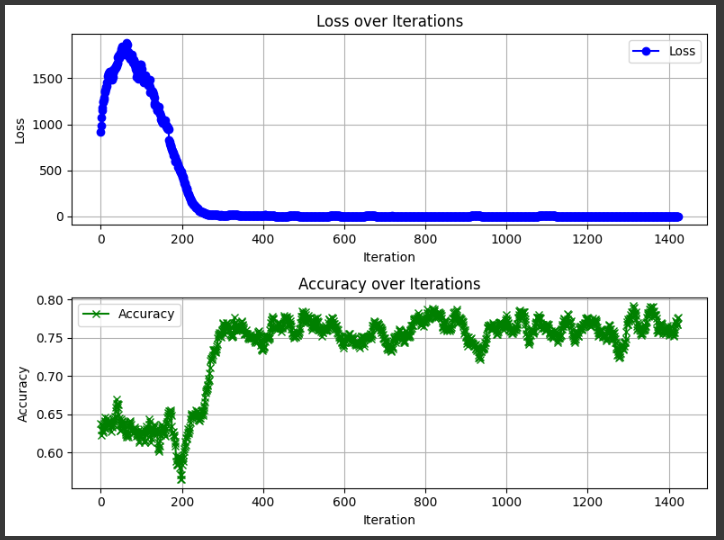

**Trigrams**

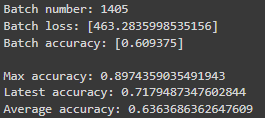
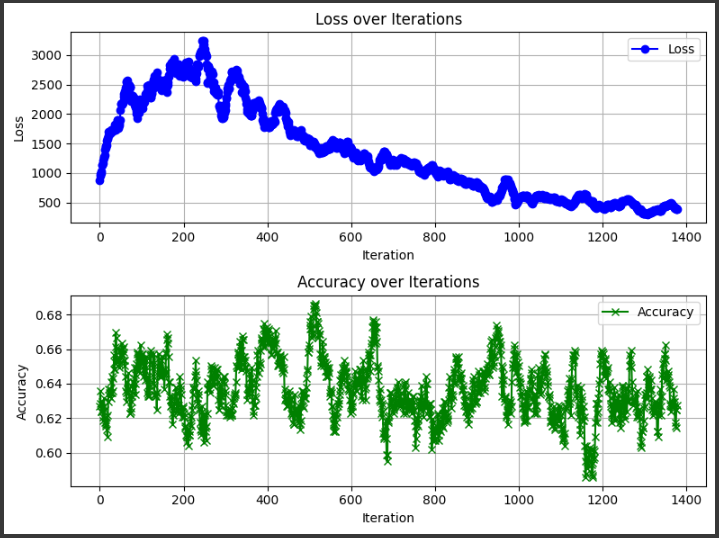

<a id = 'embed'></a>
[Back to Table of Contents](#home)
### Word Embeddings

Word embeddings are dense vector representations of words in a continuous vector space, typically in a high-dimensional space. Each word in a vocabulary is represented by a unique vector, where the vector values capture semantic relationships between words based on their context in a corpus of text data. 

Word embeddings are learned through unsupervised learning techniques, such as neural network architectures like Word2Vec, GloVe, or FastText.
### Word2Vec: Skip-gram, Continuous Bag of Words (CBoW), TensorFlow Embedding
#### Skip-gram
- a type of word embedding (Word2Vec)
- preserves the order of words in the input text
- skip-grams consider tokens within a specified window size, skipping some number of tokens in between
- input: a single target word
- output: a probability distribution over the context words
  - indicates the likelihood of each context word __appearing in the vicinity__ of the target word
- performs better on large datasets and for infrequent words
  - considers each context word separately, so it captures subtle semantics
 
#### Continuous Bag of Words (CBoW)
- a word embedding model used to learn distributed representations of words while taking context into account
- input: a bag of context words (context window)
- output: a probability distribution of the vocabulary
  - indicates the likelihood of each word __being the target word__ given the context
- similar to skip-gram, but learns with a different objective
- performs well for small datasets with high frequency words
  - averages context vectors, might lose subtle semantics in the process
 
**Verdict:**
From these two, we chose **skip-grams** because it **tends to perform better on larger datasets**, according to Mikolov et al. (2013), the authors of the Word2Vec paper titled "Efficient Estimation of Word Representations in Vector Space". The reason behind this observation is that skip-gram models are more effective at capturing the relationships between words when trained on large amounts of text data, as they are designed to predict context words from a given target word. This process allows the model to learn embeddings that are more sensitive to the surrounding context of each word.

#### TensorFlow: Embedding layer
We will also make use of the Embedding layer in TensorFlow, a specialized layer used for learning word embeddings in neural networks. It will be used as the first layer in the architecture.

The embedding layer learns the dense vector representations (embeddings) of the input words or categories during training. These embeddings can then be used as features in subsequent layers of the neural network model.

<a id = 'expembed'></a>
[Back to Table of Contents](#home)
### Experiments: Word Embeddings

The overall methodology here is similar to the experiments above. It has the same model architecture and same main training/validation flow. The **main difference** is that we will be using skipgrams for one, and an Embedding layer on the latter one, which was not used in any of the models before.

**Baseline ANN Architecture**
- OPTIONAL ```Embedding(input_dim = 77413, output_dim = 256)```: An embedding layer with an output dimension of 256, which learns to map each word to some vector representation as part of the training process
- OPTIONAL ```tf.keras.layers.GlobalAveragePooling1D()```
- ```Dense(256, activation='relu')```: A fully connected layer with 256 neurons and a ReLU activation function.
- ```Dense(128, activation='relu')```: A fully connected layer with 128 neurons and a ReLU activation function.
- ```Dense(5, activation='softmax')```: An output layer with 5 neurons and a softmax activation function, which represents the output probabilities for each class.

**Methodology**
- Based on the [discussion](#datasize) on how we handled the size of the dataset for training, we opted to use the entire training dataset for training/validation since we will lose a significant amount of data in the event that the chosen sample is not representative, which is easy to mess up considering that the input data is text.
- Summary of the steps:
  - Load the dataset using ```tf.data.experimental.make_csv_dataset()```
  - Load the tokenizer using ```tf.keras.preprocessing.text.tokenizer_from_json()``` from a previously saved JSON file representing the trained tokenizer
  - Instantiate the model architecture as specified above with hyperparameters:
    - ```optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']```
    - Optionally with ```Embedding``` and ```GlobalAveragePooling1D()``` layers ad-hoc
  - Iterate through the loaded dataset in batches with ```trainBatchSize = 256```, which was the biggest that Colab can handle without using up all the GPU RAM. It can handle 512, but we had to run it one at a time and not the entire file at once.
    - Obtain batch of text as a list with processing steps, e.g., ```decode()```, because of how the dataset is loaded via ```tf.data.experimental.make_csv_dataset()```
    - Optionally generate skipgrams and fit onto the training data
    - One-hot encoding for the labels since we are using softmax
    - Fit and track metrics
- The only independent variable here is the word embedding process: skipgrams vs a TensorFlow Embedding layer
   
**IMPORTANT**: We will largely be following this set of steps for training in later stages, except for when we get to some of the pre-trained models, where fine-tuning reduces resource usage.

The code above remains largely the same for skipgrams and the TF Embedding implementation except for the preprocessing and layers as specified in the description of the experiment just above the code block.

#### Final outputs
Final outputs from the external notebook, truncated to the final batches with summary metrics for brevity:

**Skipgrams**

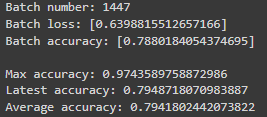
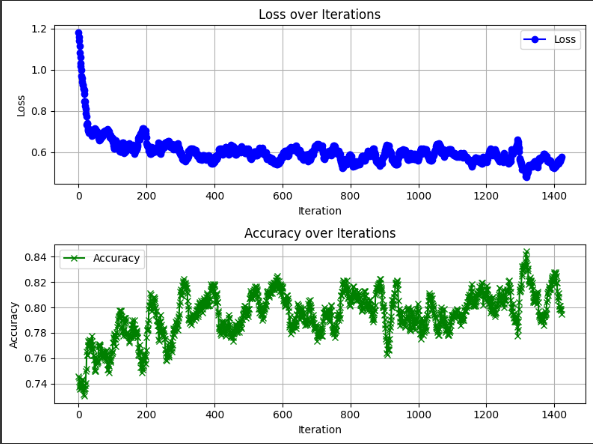


**Embedding Layer**

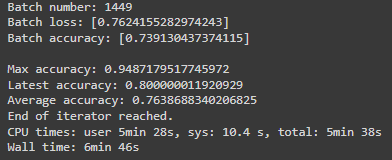
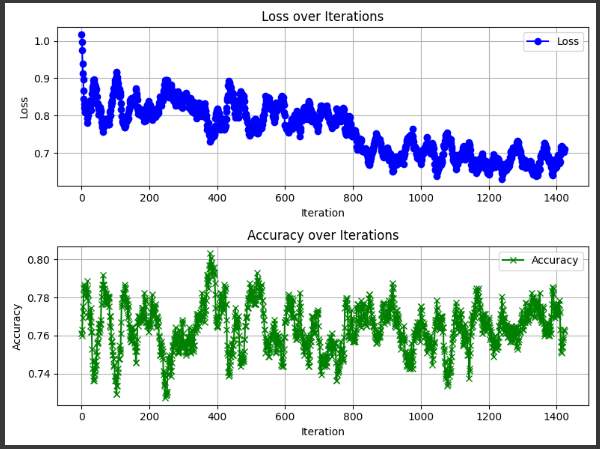

<a id = '3summary'></a>
[Back to Table of Contents](#home)
### Discussion and Summary

Note that with the amount of data that needed training, we decided to train with 1 epoch over the whole dataset, instead of a stratified sample and more epochs since there would be a significant loss in potential learning if we sampled. 
#### Bag of Words
- ```mode = count```:
  - Loss: The loss was still going down smoothly until the end, so more epochs could have helped it converge
  - Accuracy: The accuracy was quite volatile because of the frequent weight updates, but it was increasing up until around batch 1000, where it kind of tapered off and was just volatile yet remaining around 0.81 (testing) accuracy
- ```mode = binary```:
  - Loss: Similar story with ```count```
  - Accuracy: The accuracy was still quite volatile but visibly less so compared to ```count```; the gaps between the rises and drops were wider. It also peaked later in terms of batches compared to ```count```. There was also quite a huge dip by around batch 550, until it went back up. Simply put, it seemed to have an upward trend in the beginning, then it reduced, then went back up again, more than the previous peak, which repeated in later iterations.
- ```mode = tfidf```:
  - Loss: Similar story with ```binary```, but a bit more volatile, with some mini peaks occurring between batches 300 to 1000 at around the same value
  - Accuracy: The accuracy here is also volatile, but at wider margins between rises and drops compared to ```binary```. There is an evident upward trend as well, so more epochs might have helped. Unfortunately, resource limitations with Colab only allow a certain amount of time before the runtime is allocated to others.
#### N-grams
- Bigrams:
  - Loss: The loss quickly plateaued close to zero at around 250 batches, which is close to only 20% of the data trained.
  - Accuracy: The accuracy was hovering at around 0.63 until it dropped at batch 200, with a subsequent rise in accuracy relatively quickly (to around 0.77). It then proceeded to hover at around that accuracy for the rest of the training period.
- Trigrams:
  - Loss: Significantly harder to train/optimize compared to bigrams considering the combinations available. It started at a loss of around 1000, then proceeded to peak at around batch 250, where it then gradually went down as more data was fed into the model.
  - Accuracy: This is the most volatile one out of all, with no semblance that it was really learning anything. It stayed at around 0.64 with peaks to 0.66 and drops to 0.6, at one point going as far as 0.58.
#### Word Embedding
- Skipgrams:
  - Loss: Gradually went down, and might still go down with more epochs.
  - Accuracy: Volatile; there is a visible upward trend, some semblance of plateauing but not certain.
- TensorFlow's Embedding layer:
  - Loss: Gradually going down, albeit with more volatility than skipgrams.
  - Accuracy: Significantly more volatile than skipgrams, little to no semblance of learning.
 
#### Summary:
With the experiments above, it is shown that the choice of text representation technique and n-gram size can significantly impact how models learn and perform. While simpler approaches like BoW may converge faster, more complex techniques like n-grams and word embeddings offer the potential for capturing richer semantic information in the text, albeit with increased computational complexity and training challenges. 

It was especially evident with n-grams, where the differences in learning between bigrams and trigrams were quite significant. With bigrams, the performance plateaued early on in training, possibly due to the common occurrences of bigrams. However, with trigrams, there were too many combinations to learn about, making it more complex and resource-hungry for convergence (close to twice the time required to train).

With word embeddings, skipgrams and TensorFlow's ```Embedding``` layer both showed potential for learning, with skipgrams demonstrating slightly more stable accuracy trends. More epochs might have been necessary to truly understand the behaviour.

<a id = 'nlog'></a>
[Back to Table of Contents](#home)
### Extra: N-grams with Logistic Regression: Lemmatization vs Stemming
This experiment with stemming vs lemmatization was done on a different notebook. Please contact any one of the team members for the code if necessary.

The logistic regression was done on scikit-learn with default parameters.

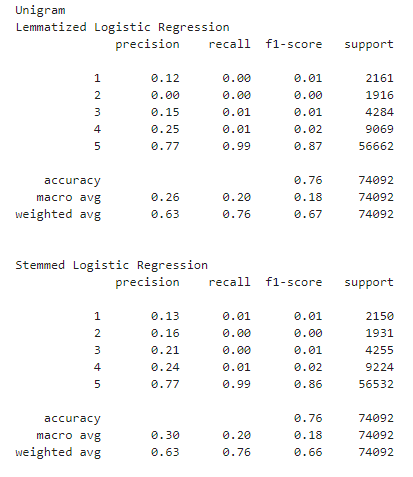

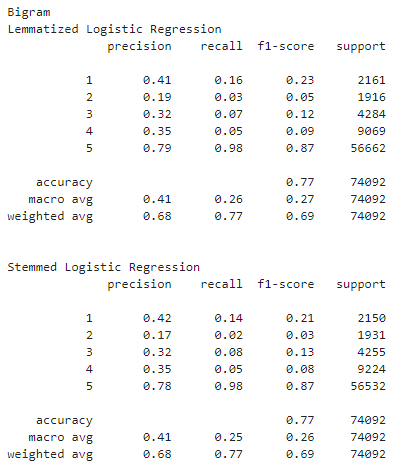

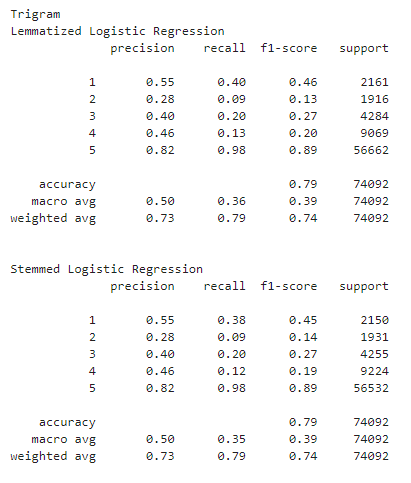

Based on the above results obtained from [this notebook](./unibitri.ipynb), the best one was the trigram representation due to the higher potential of learning from three-word sequences, offering more patterns/relationships to be found. However, this also took the longest because of the complexity of three-word sequences.

<a id = 'modelTraining'></a>
[Back to Table of Contents](#home)
## D. Model Training/Selection, Hyperparameter Tuning/Evaluation
You should at least experiment with 3 models and show how you can optimize model parameters using cross validation. For each model, discuss your choices of text processing, representation, and features from steps 1-3.

For this part, we experimented with 3 relatively simple models with differing configurations before we moved on to using pre-trained models for fine-tuning:
- Simple Neural Network
- Bidirectional LSTM
- Simple CNN

The differing parameters were:
- The training/testing datasets
  - Raw (done on pre-trained datasets, not here because it's noisy)
  - Preprocessed with no truncation (still a bit noisier than required)
  - **Lemmatized**
    - lemmatized retained the proper base words, so we used this for most of our experiments
    - especially since it was shown in the ```LogisticRegression``` experiment that while marginally, it was still better than stemmed
  - Stemmed
  - performance was on par with lemmatized, but was lower marginally, and took twice the time to finish
- Some model specific hyperparameters

To easily train models without having to wait for one to finish, we trained and tested them on different notebooks. **Here, we will show a summary of the architecture, the datasets used in each experiment, and the relevant metrics that the models obtained.** This section then serves as a consolidation, discussion, and analysis for the results on these models. We also used the same training/testing flow as above, so copy/pasting the code will just lengthen this notebook:

**Methodology**
- Based on the [discussion](#datasize) on how we handled the size of the dataset for training, we opted to use the entire training dataset for training/validation since we will lose a significant amount of data in the event that the chosen sample is not representative, which is easy to mess up considering that the input data is text.
- Summary of the steps:
  - Load the dataset using ```tf.data.experimental.make_csv_dataset()```
  - Load the tokenizer using ```tf.keras.preprocessing.text.tokenizer_from_json()``` from a previously saved JSON file representing the trained tokenizer
  - Instantiate the model architecture as specified above with hyperparameters:
    - ```optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']```
  - Iterate through the loaded dataset in batches with ```trainBatchSize = 256```, which was the biggest that Colab can handle without using up all the GPU RAM. It can handle 512, but we had to run it one at a time and not the entire file at once.
    - Obtain batch of text as a list with processing steps, e.g., ```decode()```, because of how the dataset is loaded via ```tf.data.experimental.make_csv_dataset()```
    - Preprocess the data appropriately to represent it in a specific format/representation for training
    - One-hot encoding for the labels since we are using softmax
    - Fit and track metrics

**If you wish to view the source code for these models, please contact any one of our team members.**

#### Model Training

**Cross-validation**

For all the models here, we opted for 5-fold cross-validation. We found that 10-fold cross-validation took too long to run, and since we have a relatively big dataset, we were able to opt for only 5 folds. We also conducted a small test on the SNN: the accuracies were not visibly affected, with only a 0.01 difference in accuracies, but with a faster training time. Hence, we used 5 folds for the simpler models.

**The models we used**

For convention, we refer to a simple neural network (or **SNN**) in this cell as a model with the following architecture unless mentioned otherwise:
- ```Dense(256, activation = 'relu')```
- ```Dense(128, activation = 'relu')```
- ```Dense(5, activation = 'softmax')```
- with ```adam``` optimizer and categorical cross entropy loss

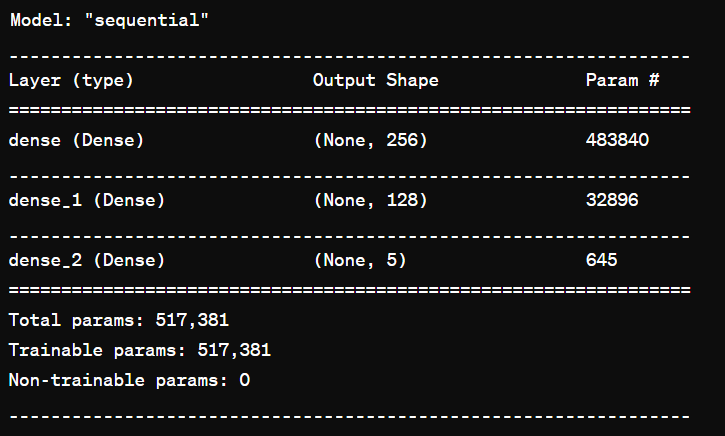

We experimented with SNN in the following ways:
1. SNN with TF-IDF weighting, 1 epoch, lemmatized dataset
   - above architecture
2. SNN with BoW ```mode = count```, 1 epoch, lemmatized dataset
   - above architecture
3. SNN with Dropout layers and TF-IDF weighting, 1 epoch, lemmatized dataset
   - 256relu, 0.3dropout, 128relu, 0.3dropout
4. SNN with Dropout layers and BoW ```mode = count```, 1 epoch, lemmatized dataset
   - 256relu, 0.3dropout, 128relu, 0.3dropout
5. SNN with Dropout layers and BoW ```mode = count```, more nodes per layer, 1 epoch, lemmatized dataset
   - 1024relu, 0.3dropout, 512relu, 0.3dropout

Here, we refer to a bidirectional LSTM as a model with the following architecture unless mentioned otherwise:
- ```Bidirectional(LSTM(128))```
- ```Dropout(0.2)```
- ```Flatten```
- ```Dense(128, activation = 'relu')```
- ```Dropout(0.2)```
- ```Dense(5, activation = 'softmax')```
- with ```adam``` optimizer and categorical cross entropy loss

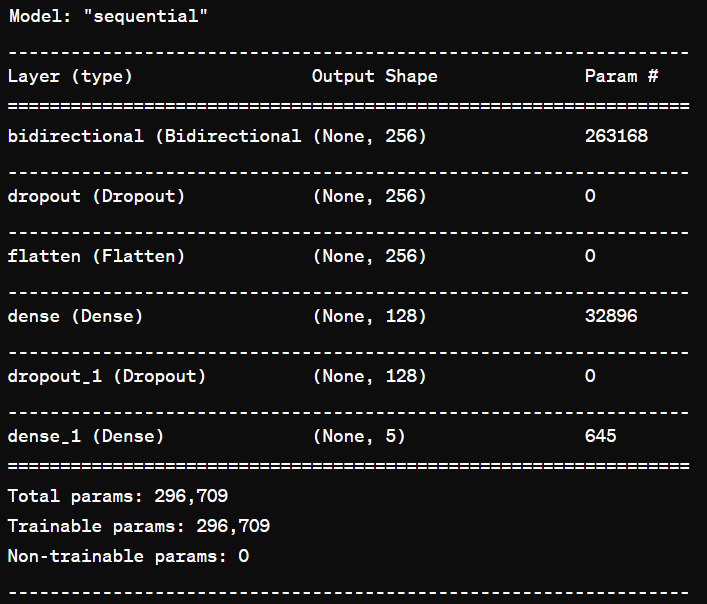

6. Bidirectional LSTM, 1 epoch
   - above architecture
7. Bidirectional LSTM, 4 epochs
   - above architecture
8. Bidirectional LSTM, 5 epochs
    - above architecture
  
Here, we refer to a simple CNN as a model with the following architecture unless mentioned otherwise:
- ```Embedding(vocabSize, embedding_dim = 128, input_length = 1885)```
- ```Conv1D(128, 5, activation = 'relu')```
- ```GlobalMaxPooling1D()```
- ```Dense(128, activation = 'relu')```
- ```Dropout(0.2)```
- ```Dense(5, activation = 'softmax')```
- with ```adam``` optimizer and categorical cross entropy loss

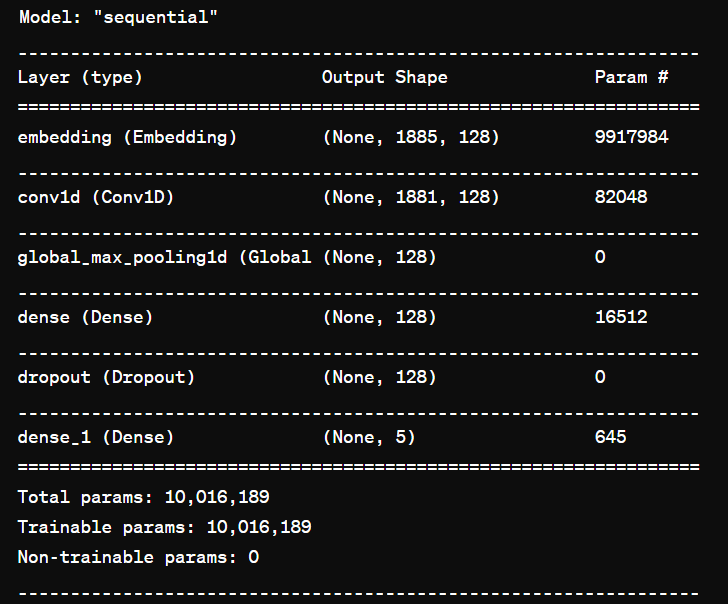

9. Simple CNN with TF-IDF weighting, 1 epoch
10. Simple CNN with TF-IDF weighting, slightly more complex, 1 epoch
    - 256, conv1d-128-5-relu, maxpooling, 128relu, 0.2dropout
   
#### Summary of model results on Kaggle
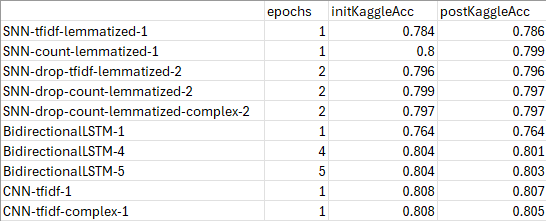

#### Brief analysis of the results + extras
- **Decision**: We had to decide between training the entire dataset on a handful of epochs, or a stratified sample with 10s of epochs. We chose the former because of the potential information loss.
- **Undersampling experiment**: Early on, we tried experimenting between using the same dataset, which is imbalanced, and a dataset which was balanced using undersampling. The results were significantly worse, only reaching low 70s. This is most likely due to the inherent imbalance in the class distribution, which was also discussed in a previous section of this paper which talked about negativity bias. Hence, **we kept the imbalance**.
- **Complexity of patterns**
  - Due to the complexity of possible patterns to be learned within text, especially with Amazon reviews, CNNs were most effective out of the 3 chosen models because of its effectiveness at finding said patterns compared to the other two
  - The bidirectional LSTM was on par with the CNN with regards to performance/accuracy, but was likely struggling with more local, closer sequences or dependencies compared to the CNN
  - The architecture we have created was intentionally a baseline model to put up against others, so the behavior is expected.
- **Training efficiency**
  - CNNs were the most efficient, just ahead of the SNN, with the bidirectional LSTM lagging behind due to its sequential nature, which was also apparent in the GPU usage with the same batch size across all training
- **Tuning**
  - The fact that there were more tunable hyperparameters for the CNN and bidirectional LSTM likely resulted in them being able to capture the nuances more effectively, even if we tuned manually
- **Bonus: Stemming**
  - We trained some models on stemmed data, but it was marginally worse than the models trained on lemmatized data, so they were not recorded as reliably

<a id = 'modellingText'></a>
[Back to Table of Contents](#home)
## E. Modelling Text as a Sequence
So far, you have investigated the document as a 'bag-of-word' model. Bag-of-word models fail to take advantage of the semantic meaning present in word ordering. Experiment with at least one model that looks at the text as a sequence (RNN, LSTM, Transformers, ...). Document your results and compare to the bag-of-word representation models in steps 2-4.

For this part, we experimented with 4 models that rely on a representation of sequences:
- Bidirectional LSTM (discussed and displayed results in the previous section)
- BERT-base-uncased, [for reference](https://huggingface.co/google-bert/bert-base-uncased), by Devlin et al. (2018)
- BERT pretrained on Amazon reviews, [for reference](https://huggingface.co/amir7d0/distilbert-base-uncased-finetuned-amazon-reviews), by amir7d0
- A custom transformer, trained on the dataset itself

<a id = 'bertbase'></a>
[Back to Table of Contents](#home)
### BERT
BERT is a large tranformer model with 12 transformer layers pretrained on a large corpus of English data (in essence, raw texts) in a self-supervised manner (no human labeling). It was pretrained with two objectives in mind:
- Masked Language Modeling (MLM)
  - in each document, the model randomly masks 15% of the tokens in the document
  - it then runs the masked document through the model and tries to predict the masked words
  - it is novel in that:
    - with traditional RNNs, the model sees the tokens one after another, or in sequence
    - with autoregressive models like GPT that internally mask future tokens
    - this allows the model to learn a bidirectional representation of the document
- Next Sentence Prediction (NSP)
  - the model concatenates two masked documents as input during pretraining
  - the model then has to predict if the two sentences follow each other or not (if they come in sequence anywhere)

#### How we implemented it

We made use of two models: BERT-base-uncased and BERT-large-uncased. We focused more of our resources into training BERT-large-uncased to have better chances of winning. Both were fine-tuned to the dataset provided with a train/test split = 0.2. To be able to handle the computational complexity, we leveraged the High Performance Computing (HPC) facility of Heriot-Watt, or simply, **dmog**.

Below is the code we used to finetune the models. We fine-tuned for 10 epochs on both models, saving the model and the test results on the actual testing data per epoch, with these hyperparameters:
- ```max_length = 128```
- ```batch_size = 128```
- ```num_epochs = 10```
- ```learning_rate = 2e-5```

The only difference in the code between the two is changing ```bert_model_name``` when appropriate.

In [ ]:
import os
import torch
import pandas as pd
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# This is so I don't have to keep uploading on Colab.
import requests
from requests.auth import HTTPBasicAuth

class BERTClassifier(nn.Module):
  def __init__(self, bert_model_name, num_classes):
      super(BERTClassifier, self).__init__()
      self.bert = BertModel.from_pretrained(bert_model_name)
      self.dropout = nn.Dropout(0.1)
      self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

  def forward(self, input_ids, attention_mask):
      outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
      pooled_output = outputs.pooler_output
      x = self.dropout(pooled_output)
      logits = self.fc(x)
      return logits
  
class TextClassificationDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_length):
          self.texts = texts
          self.labels = labels
          self.tokenizer = tokenizer
          self.max_length = max_length
  def __len__(self):
      return len(self.texts)
  def __getitem__(self, idx):
      text = str(self.texts[idx])
      label = self.labels[idx]
      encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
      return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label-1)}
  
def train(model, data_loader, optimizer, scheduler, device):
  model.train()
  for i,batch in enumerate(data_loader):
      optimizer.zero_grad()
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)
      outputs = model(input_ids, attention_mask)
      loss = nn.CrossEntropyLoss()(outputs, labels)
      if i % 100 == 0:
        print(f"Batch: {i}")
      loss.backward()
      optimizer.step()
      scheduler.step()

def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)

def predict_sentiment(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
    return preds.item()
    
df = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
df_test['Review'] = df_test['Review'].astype(str)
texts = df['Review'].tolist()
labels = df['overall'].tolist()

bert_model_name = 'bert-large-uncased'
num_classes = 5
max_length = 128
batch_size = 128
num_epochs = 10
learning_rate = 2e-5

train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)
#Training on the entire dataset while keeping the validation same.
train_texts = texts
train_labels = labels

tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)
# If you are doing the load and train thing, use this to load:
# model.load_state_dict(torch.load(f"/bert{epoch}e.pt"))
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train(model, train_dataloader, optimizer, scheduler, device)
    accuracy, report = evaluate(model, val_dataloader, device)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(report)
    torch.save(model.state_dict(), f"./bertne{epoch}e.pt")
    df_submission = pd.DataFrame()
    df_submission['id'] = df_test['id']
    for index, row in df_test.iterrows():
        value = predict_sentiment(row['Review'], model, tokenizer, device)
        df_submission.at[index, 'overall'] = value
    df_submission.to_csv(f"./submissionBertNE{epoch + 1}Epochs.csv", index = False)

#### Results of BERT-base-uncased

#### Results of BERT-large-uncased

#### Summary of Results with Kaggle
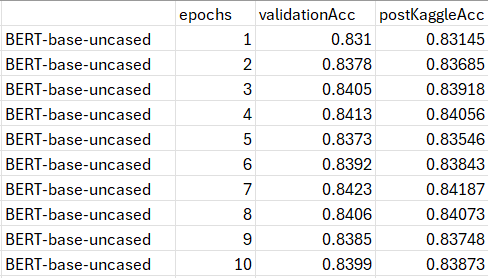

Here, we see that more epochs don't necessarily mean a better accuracy because of the risk of overfitting. To be sure, we submitted all 10 epochs for BERT-base-uncased. However, when we were submitting BERT-large-uncased, we only had a few submissions left and too many ideas. One of them was to train on everything with no validation, which is not a good strategy in practical machine learning projects, but for the sake of winning the competition, we tried it, and below are the results.

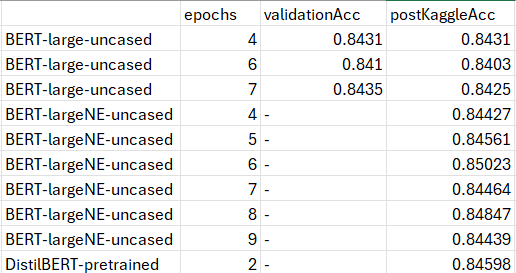

**They worked quite well, but it is not advisable to do this in real-world applications which have real implications.**

<a id = 'amazon'></a>
[Back to Table of Contents](#home)
### DistilBERT Amazon Pre-trained
This model is a uncased, distilled version of the BERT base model, with half the transformer layers and half the parameters. It was introduced by Sanh et al. (2019) in their work titled 'DistilBert, a distilled version of BERT: smaller, faster, cheaper, and lighter'.

It was trained using 'knowledge **distillation**', where it learns from the outputs of a pre-trained BERT model. It tries to replicate the behaviour of the larger BERT model, but with significantly fewer parameters with a focus on efficiency.

We ran it once as a proof-of-concept in similar format to the former BERT models, with the results shown in the table above under DistilBERT-pretrained. It was interesting and had potential, but we ran out of submissions by that time.

<a id = 'custom'></a>
[Back to Table of Contents](#home)
### Extra: Custom Transformer

We tried to implement a custom transformer (1 layer) and train it from the ground up, but it was too resource-intensive, only being able to achieve ~76% accuracy at ~2 epochs, which makes intuitive sense since it needs to be trained more. It was run on Google Colab, so it was at the mercy of their reliability, which caused it to stop at batch number 9048. It was run on another notebook, but the validation results and code are placed below.

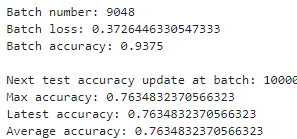

In [ ]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.self_attn = nn.MultiheadAttention(d_model, num_heads, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output, attn_output_weights = F.multi_head_attention_forward(
            query=x, key=x, value=x, embed_dim_to_check=x.size(-1),
            num_heads=self.self_attn.num_heads,
            in_proj_weight=self.self_attn.in_proj_weight,
            in_proj_bias=self.self_attn.in_proj_bias,
            bias_k=self.self_attn.bias_k,
            bias_v=self.self_attn.bias_v,
            add_zero_attn=self.self_attn.add_zero_attn,
            dropout_p=self.self_attn.dropout,
            out_proj_weight=self.self_attn.out_proj.weight,
            out_proj_bias=self.self_attn.out_proj.bias,
            training=True,  # Set training to True
            key_padding_mask=mask,
            need_weights=False,
            attn_mask=None,
            use_separate_proj_weight=False,
            q_proj_weight=None,
            k_proj_weight=None,
            v_proj_weight=None,
            static_k=None,
            static_v=None,
            average_attn_weights=False,
            is_causal=False)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, num_classes, dropout):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)
        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.fc = nn.Linear(d_model, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.dropout(self.positional_encoding(self.embedding(x)))

        enc_output = embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, None)

        # Global average pooling
        pooled_output = enc_output.mean(dim=1)

        logits = self.fc(pooled_output)
        return logits

# Instantiate the Transformer model
vocab_size = 77414  # Example vocabulary size
d_model = 256
num_heads = 8
num_layers = 6
d_ff = 1024
max_seq_length = 1885
num_classes = 5  # Example number of classes
dropout = 0.1

model = TransformerClassifier(vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, num_classes, dropout)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} for processing")
model = model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

dataset = pd.read_csv("data/trainLemmatized.csv")
training, testing = train_test_split(dataset, stratify = dataset['labels'], test_size=0.1, random_state=42)
training.to_csv("data/trainLemmatizedTr.csv", index = False)
testing.to_csv("data/trainLemmatizedTe.csv", index = False)

# # Empirical value
# MAXLENGTH = 1885

# # Loading stemmed tokenizer from the JSON file
# with open("data/stemTokenizer.json", "r") as json_file:
#     tokenizerJSON = json_file.read()
#     stemTokenizer = tf.keras.preprocessing.text.tokenizer_from_json(tokenizerJSON)
# stemVocabSize = len(stemTokenizer.word_index)
# print(f"Stemmed Tokenizer loaded successfully with {stemVocabSize} words.")

# Determines number of rows per batch to process on
trainBatchSize = 32

lemmatizedDataset = tf.data.experimental.make_csv_dataset("data/trainLemmatizedTr.csv",
                                                batch_size = trainBatchSize,
                                                select_columns = ["data", "labels"],
                                                label_name = "labels",
                                                num_epochs = 5,
                                                shuffle_seed = 43,
                                                shuffle = True)

# Loading tokenizers from the JSON files
with open("data/lemmaTokenizer.json", "r") as json_file:
    tokenizerJSON = json_file.read()
    lemmaTokenizer = tf.keras.preprocessing.text.tokenizer_from_json(tokenizerJSON)
lemmaVocabSize = len(lemmaTokenizer.word_index)
print(f"Lemmatized Tokenizer loaded successfully with {lemmaVocabSize} words.")

from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
!mkdir models

# Iterator to avoid loading the entire dataset
iterator = iter(lemmatizedDataset)

# To keep track of which batch we're operating on
TESTINTERVAL = 5000
accuracy = 0
progress = 0
updateAccuracy = 5000
maxAccuracy = 0
aveAccuracy = 0
batch_loss = 0
batch_accuracy = 0
totalLoss = 0
totalCorrect = 0
totalSamples = 0

dataset = pd.read_csv("data/trainLemmatizedTe.csv")
training = dataset['data'].tolist()
testing = dataset['labels'].tolist()

training = [str(item) for item in training]
training = lemmaTokenizer.texts_to_sequences(training)
training = tf.keras.preprocessing.sequence.pad_sequences(training, maxlen=max_seq_length, padding="post")

testing = [x - 1 for x in testing]
testing = tf.keras.utils.to_categorical(testing, num_classes = 5)

training = torch.tensor(training)
training = training.to(device)
testing = torch.tensor(testing)
testing = testing.to(device)
toTest = TensorDataset(training, testing)
dataset = DataLoader(toTest, batch_size=trainBatchSize, shuffle=False)

try:
  while True:
    # Admin stuff
    model.train()
    progress = progress + 1
    if progress % TESTINTERVAL == 0:
      updateAccuracy = progress
    clear_output(wait = True)
    print(f"Batch number: {progress}")
    print(f"Batch loss: {batch_loss}")
    print(f"Batch accuracy: {batch_accuracy}\n")
    print(f"Next test accuracy update at batch: {updateAccuracy}")
    print(f"Max accuracy: {maxAccuracy}")
    print(f"Latest accuracy: {accuracy}")
    print(f"Average accuracy: {aveAccuracy}")


    # Obtain batch of text as a list
    batch = next(iterator)
    current = batch[0]['data'].numpy().tolist()
    decoded = list(map((lambda x : x.decode()), current))

    # Keep track of labels of each batch
    currentLabels = batch[1].numpy().tolist()

    tokenizedDocs = lemmaTokenizer.texts_to_sequences(decoded)
    paddedData = tf.keras.preprocessing.sequence.pad_sequences(tokenizedDocs, maxlen=1885, padding="post")

    currentLabels = [x - 1 for x in currentLabels]
    currentLabels = tf.keras.utils.to_categorical(currentLabels, num_classes = 5)

    padded_data_tensor = torch.tensor(paddedData)
    current_labels_tensor = torch.tensor(currentLabels)
    train_dataset = TensorDataset(padded_data_tensor, current_labels_tensor)
    train_dataloader = DataLoader(train_dataset, batch_size=trainBatchSize, shuffle=True)

    totalLoss = 0
    totalCorrect = 0
    totalSamples = 0

    for batch_inputs, batch_labels in train_dataloader:
        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)
        optimizer.zero_grad()  # Clear gradients
        # print(batch_inputs)
        # print(f"Length of inputs: {len(batch_inputs)}")
        # print(batch_labels)
        # print(f"Length of labels: {len(batch_labels)}")
        outputs = model(batch_inputs)  # Forward pass
        # loss = criterion(outputs.view(-1, num_classes), batch_labels)
        loss = criterion(outputs, batch_labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update parameters
        totalLoss += loss.item() * batch_inputs.size(0)
        actual = batch_labels.argmax(dim = 1)
        _, predicted = torch.max(outputs, 1)
        totalCorrect += (predicted == actual).sum().item()
        totalSamples += batch_inputs.size(0)

    batch_loss = totalLoss / len(train_dataset)
    batch_accuracy = totalCorrect / totalSamples

    if progress % TESTINTERVAL == 0:
      val_loss = 0
      val_correct = 0
      val_samples = 0
      model.eval()
      with torch.no_grad():
        print()
        print("Saving model...")
        torch.save(model.state_dict(), f"models/groundUpTransformerB{progress}.pth")
        print(f"Model saved under: models/groundUpTransformerB{progress}.pth")
        for i, (batch_inputs, batch_labels) in enumerate(dataset):
            if i % 100 == 0:
              print(f"Testing batch {i} to {i + 100}")
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)
            outputs = model(batch_inputs)
            val_loss += criterion(outputs, batch_labels).item() * batch_inputs.size(0)
            actual = batch_labels.argmax(dim = 1)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == actual).sum().item()
            val_samples += batch_inputs.size(0)
        accuracy = val_correct / val_samples
      if maxAccuracy < accuracy:
        maxAccuracy = accuracy
      aveAccuracy = (((aveAccuracy * (progress - 1)) + accuracy) / (updateAccuracy / TESTINTERVAL))
      updateAccuracy = updateAccuracy + TESTINTERVAL

except StopIteration:
  print("End of iterator reached.")

# # Split data into training and validation sets
# train_texts, val_texts, train_labels, val_labels = train_test_split(padded_texts, labels, test_size=0.2, random_state=42)

# batch_size = 64

# # Create TensorFlow Dataset
# train_dataset = tf.data.Dataset.from_tensor_slices((train_texts, train_labels))
# train_dataset = train_dataset.batch(batch_size)

# val_dataset = tf.data.Dataset.from_tensor_slices((val_texts, val_labels))
# val_dataset = val_dataset.batch(batch_size)

# testDataset = tf.data.Dataset.from_tensor_slices(val_texts)
# testDataset = testDataset.batch(batch_size)

#### Comparison with results from BoW models
Sequence representation models, such as transformer-based architectures like BERT and LSTM-based models in our case, have demonstrated *superior performance* compared to the BoW models in our project in the context of text classification. There was at least a **5% difference in accuracy** with the best BoW model and the best transformer-based architecure. This is primarily because sequence representation models capture the contextual relationships and dependencies between words in a sentence, whereas BoW models treat each word independently without considering their order or context, losing important information which it really cannot capture well.

<a id = 'topicModelling'></a>
[Back to Table of Contents](#home)
## F. Topic Modelling of High and Low Ratings
Examine the 5-star reviews and the 1-star reviews separately. Categorize each review into a set of topics (10 - 20 topics). Can you infer any particular observations regarding the topics discussed in the highly rated reviews vs the lowly rated reviews? Document any other observations you have gained with this analysis. You may use a smaller subset of the reviews to better demonstrate your findings.

In this section, we leveraged the capabilities of both **word clouds** and **pyLDAvis** for topic modelling. 

In [54]:
#PyLDAvis

from gensim import corpora
from gensim.models.ldamodel import LdaModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
pyLDAvis.enable_notebook()

def pyLDAvisualization(inp, n=10, p=10):
  # Create a dictionary representation of the documents
  dictionary = corpora.Dictionary(inp)
  # Convert dictionary into a BoW
  corpus = [dictionary.doc2bow(text) for text in inp]

  #LDA model
  lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=n, passes=p)

  #generating visualization
  vis = gensimvis.prepare(lda_model, corpus, dictionary)
  return vis

In [ ]:
n15p10 = pyLDAvisualization(reviews['processed'], 15, 10)

In [ ]:
pyLDAvis.display(n15p10)

Topics breakdown and interpretation
- 1 : The reviews dont seem to be regarding a specific product, but the product(s) may be on the higher end in terms of pricing.
      In general the consumers seem to be unhppy with the pricing of the product(s).
- 2 : The reviews seem to be describing faults, damage, defects or issues with the delivered product(s).
      
- 3 : The reviews are describing coloring tools (pens, markers, pencils) and the qualities of the coloring tools.
      The words "Bright", "Vibrant", "Glitter" are used frequently.
      Indicating a mostly positive sentiment.
- 4 : The reviews are describing cutting tools (scissors, knives) and the qualities of the cutting tools.
      The words "Sharp", and "Easy" have notable appearances.
      Indicating a mostly positive sentiment.
- 5 : The reviews seem to be describing the quality of a glue product.
      The words mentioned (fabric, clay, sticks, etc) may indicate what that glue was used for.
      The word "cool" is also very exclusive to this topic, which is in line with the context which is glue guns.
- 6 : The reviews are descibing decorative items such as stickers and tape.  
      The prominence of the word christmas indicates that these products were purchased around the holiday season.
      The words "great", "loved", and "fun" indicate a postive sentiment.
- 7 : This topic revolves around painting tools for example brushes, paint, etc . The topic seems neutral, with no clear sentiment.
- 8 : This topic doesnt revolve around a specific topic, instead it appears to be about praising a product for its great value to price ratio.
- 9 : Knitting tools are the main focus of this topic. The words nice and easy are notable giving the impression of a positive sentiment.
- 10 : This topic doesnt revolve around a specific topic, instead it appears to be about praising a good product for its great value to price ratio. This topic has a highly  
       notable positive sentiment.
- 11 : The reviews are describing mostly little personal decorative items such as earrings and bracelets. This is indicated by the words "earrings", "beads", "wire", etc.
       The words "nice" and "pretty" are also used frequently which indicates a positive sentiment.
- 12 : This topic revolves around sewing machines and sewing tools. The words "sewing", "machine", "thread", "needles" are used frequently.
       The topic seems neutral.
- 13 : This topic describes decorated postal equipment such as cards and stamps. This is concluded by the words "die", and "embossing".
       The words "perfect", and "needed" indicate a positive sentiment.
- 14 : This topic is unusual and vague. On one hand it may describe scrapbooking activities and tools, but on the other hand it may positively describe th delivery of the     
       product and the initial impressions.
- 15 : This topic doesnt appear to be unique to a specific genre of products, it seems to be a collective of all the positive sentiment reviews.

## Wordcloud
We start off with initial visualization and manual removal of common words with no meaning

#### Taking All reviews with rating above 4, inclusive

In [ ]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Example positive sentiment words
all_words = text[text['overall'] >= 4]['processed'].array
text_string = ''
for i in all_words:
  text_string += ' '.join(i)
text_string = (text_string.replace('one','').replace('use',''))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_string)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

freq_4 = Counter(text_string.split()).most_common()
print(freq_4)

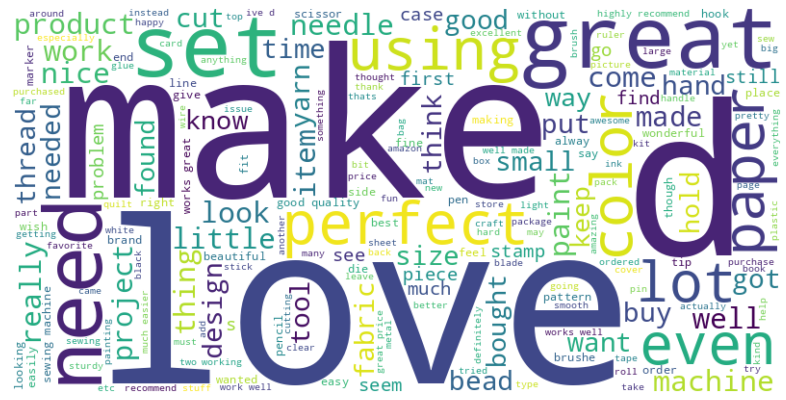

#### Words with rating equal to 3

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Example positive sentiment words
all_words = text[text['overall'] == 3]['processed'].array
text_string = ''
for i in all_words:
  text_string += ' '.join(i)
text_string = (text_string.replace('one','').replace('use',''))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_string)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

freq_3 = Counter(text_string.split()).most_common()
print(freq_3)

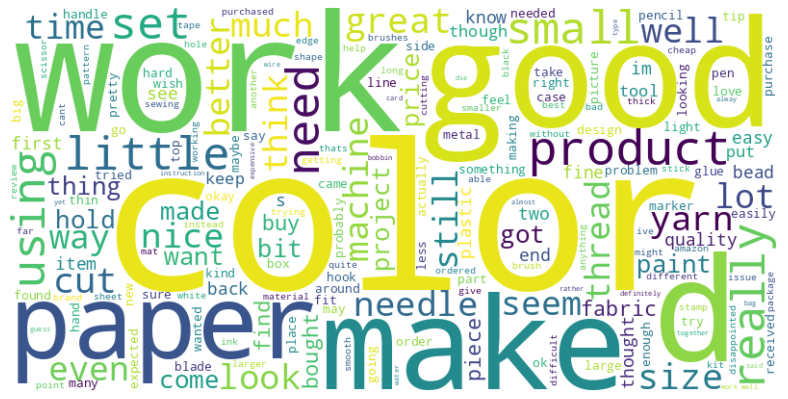

#### Words with rating less than and equal to 2

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Example positive sentiment words
all_words = text[text['overall'] <= 2]['processed'].array
text_string = ''
for i in all_words:
  text_string += ' '.join(i)
text_string = (text_string.replace('one','').replace('use',''))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_string)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

freq_2 = Counter(text_string.split()).most_common()
print(freq_2)

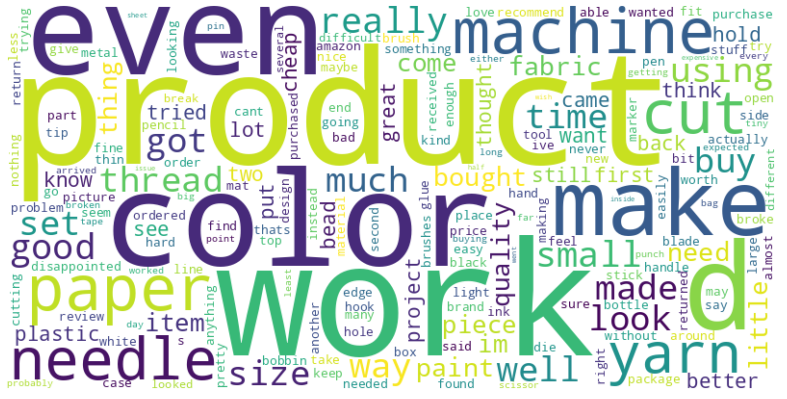

### Refining our visualization
We found the common words between all the 3 lists of words and used the euclidean distance formula on their frequencies to find their distance from each other. Following that, we removed the common words which were closest in frequencies and visualized the words using wordcloud again.

In [ ]:
import math
def calculate_distance(a, b, c):
    distance = math.sqrt((a - b)**2 + (b - c)**2 + (c - a)**2)
    return distance

In [ ]:
big_lis = []

In [ ]:
for i in freq_4[:1000]:
  for j in freq_3[:1000]:
    for k in freq_2[:1000]:
      if(i[0]==j[0] and i[0]==k[0]):
        dif = calculate_distance(i[1],j[1],k[1])
        tup = (i[0], dif)
        big_lis.append(tup)

In [ ]:
big_lis[:100]

[('great', 71750.38084916344),
 ('like', 40520.12880038759),
 ('well', 41629.92219545936),
 ('good', 39765.82756588878),
 ('love', 38991.16410162692),
 ('d', 35293.19016467624),
 ('would', 30260.96102241302),
 ('easy', 34600.16910363301),
 ('colors', 30528.85032227712),
 ('make', 30245.251428943353),
 ('product', 29089.63127989078),
 ('quality', 29417.662959521444),
 ('work', 27855.1642967691),
 ('get', 26757.437881830167),
 ('color', 28003.969290084577),
 ('little', 27196.60776641087),
 ('nice', 27312.29485048812),
 ('really', 25001.613867908607),
 ('paper', 24134.284203182822),
 ('price', 25439.84131239816),
 ('set', 24779.191431521733),
 ('time', 23326.162650551847),
 ('using', 23424.055882788532),
 ('much', 22819.40073709211),
 ('machine', 21623.882953808272),
 ('size', 20680.516241138663),
 ('also', 20051.584725402627),
 ('works', 21009.105502138827),
 ('perfect', 21405.03711746373),
 ('im', 19170.22821982044),
 ('yarn', 18634.667906887957),
 ('made', 19033.499993432633),
 ('need'

In [ ]:
sorted_data = sorted(big_lis, key=lambda x: x[1])

In [ ]:
sorted_data[:100]

[('ended', 701.3002210180744),
 ('ok', 802.9296357714043),
 ('spend', 815.2140823121249),
 ('stuck', 819.0103784446202),
 ('guess', 828.3513747196898),
 ('unless', 835.3059319794155),
 ('rough', 838.4127861620432),
 ('disappointed', 841.0743130068829),
 ('supposed', 845.9184357844437),
 ('description', 849.6316849082313),
 ('shows', 880.0318176066136),
 ('kept', 887.7172973418959),
 ('sort', 894.0212525438084),
 ('bend', 895.4027026986238),
 ('thinking', 901.6529265743),
 ('per', 907.2585078135118),
 ('dried', 918.3114939931875),
 ('resin', 918.963546611072),
 ('tension', 923.2410302840749),
 ('push', 929.3104970891053),
 ('rest', 938.5105220507653),
 ('brown', 944.6978352891468),
 ('giving', 947.8396488858228),
 ('print', 949.3197564572224),
 ('head', 951.4063274963016),
 ('pictured', 952.0808789173324),
 ('version', 953.7116964785532),
 ('stop', 955.4778909006739),
 ('50', 962.6754385565262),
 ('paid', 968.0010330573),
 ('later', 968.0919377827707),
 ('matter', 969.3925933284203),
 (

Words like disappointed might indicate that it is negative, but it could also be in the higher rated reviews

In [ ]:
frequent_meaningless_words = [item[0] for item in sorted_data[:100]]

In [ ]:
frequent_meaningless_words

['ended',
 'ok',
 'spend',
 'stuck',
 'guess',
 'unless',
 'rough',
 'disappointed',
 'supposed',
 'description',
 'shows',
 'kept',
 'sort',
 'bend',
 'thinking',
 'per',
 'dried',
 'resin',
 'tension',
 'push',
 'rest',
 'brown',
 'giving',
 'print',
 'head',
 'pictured',
 'version',
 'stop',
 '50',
 'paid',
 'later',
 'matter',
 'process',
 'designed',
 'pay',
 'middle',
 'liquid',
 'suggest',
 'entire',
 'mark',
 'separate',
 'backing',
 'as',
 'bottles',
 'leaves',
 'which',
 'smell',
 'is',
 'skein',
 'outside',
 '15',
 'means',
 'within',
 'check',
 'today',
 'center',
 'bristles',
 'cap',
 'guide',
 'ball',
 'steel',
 'knew',
 'eyes',
 'apart',
 'powder',
 'stiff',
 'gotten',
 'snap',
 'purple',
 'plate',
 'except',
 'cardboard',
 'do',
 'not',
 'totally',
 'mess',
 'children',
 'opinion',
 'coming',
 'allow',
 'wooden',
 'wool',
 'shiny',
 'tubes',
 'figure',
 'given',
 'thinner',
 'trouble',
 'original',
 'replacement',
 'inches',
 'deep',
 'directions',
 'person',
 'skeins',

In [ ]:
def remove_words_from_string(text, words_to_remove):
    words = text.split()
    filtered_words = [word for word in words if word not in words_to_remove]
    cleaned_text = ' '.join(filtered_words)

    return cleaned_text

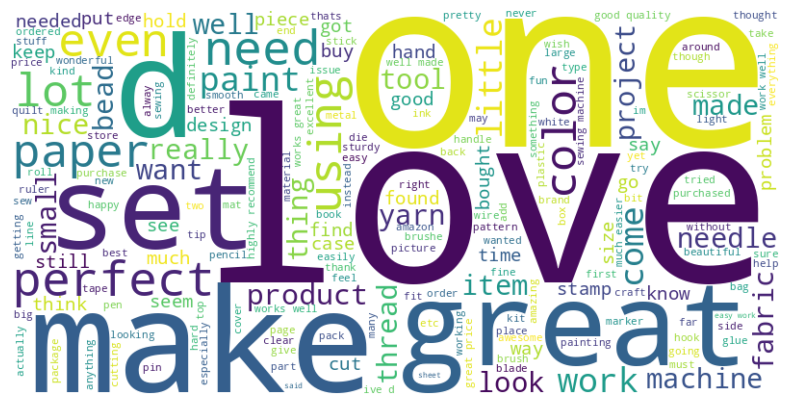

In [ ]:
all_words = text[text['overall'] >= 4]['processed'].array
all_words_string = ''
for i in all_words:
  all_words_string += ' '.join(i)
all_words_string = remove_words_from_string(all_words_string, frequent_meaningless_words)
all_words_string = all_words_string.replace('use','')
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words_string)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

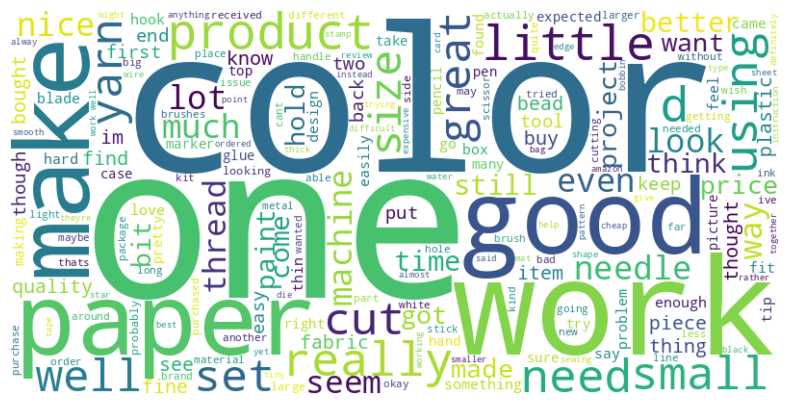

In [ ]:
all_words = text[text['overall'] == 3]['processed'].array
all_words_string = ''
for i in all_words:
  all_words_string += ' '.join(i)
all_words_string = remove_words_from_string(all_words_string, frequent_meaningless_words)
all_words_string = all_words_string.replace('use','')
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words_string)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

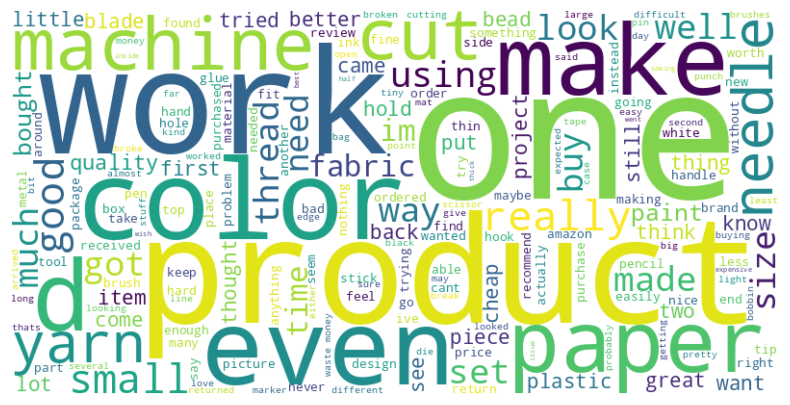

In [ ]:
all_words = text[text['overall'] <= 2]['processed'].array
all_words_string = ''
for i in all_words:
  all_words_string += ' '.join(i)
all_words_string = remove_words_from_string(all_words_string, frequent_meaningless_words)
all_words_string = all_words_string.replace('use','')
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words_string)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

<a id = 'references'></a>
[Back to Table of Contents](#home)
## References

Devlin, J., Chang, M.W., Lee, K. and Toutanova, K. (2018) Bert: Pre-training of deep bidirectional transformers for language understanding. *arXiv preprint* arXiv:1810.04805.

Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013) Efficient Estimation of Word Representations in Vector Space. *Proceedings of the International Conference on Learning Representations* (ICLR). Retrieved from https://arxiv.org/abs/1301.3781

Pan, X., Hou Y., & Wang, Q. (2023) 'Are we braver in cyberspace? Social media anonymity enhances moral courage', *Computers in Human Behavior*, 148, 107880. https://doi.org/10.1016/j.chb.2023.107880.

Sanh, V., Debut, L., Chaumond, J. and Wolf, T. (2019) DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter. *arXiv preprint* arXiv:1910.01108..